## 1. Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np

import os
import re
from collections import Counter
from wordcloud import WordCloud

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from empath import Empath

import spacy
import gensim
from gensim.corpora import Dictionary
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [79]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/madhav/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/madhav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/madhav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/madhav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
nlp = spacy.load('en_core_web_sm')

In [145]:
PATH = os.path.join(os.getcwd(), 'data', 'RMHD_Sampled.csv')
df = pd.read_csv(PATH)

In [146]:
df.head()

author  score subreddit            timestamp  \
0   quietcranberry      2   Anxiety  2019-09-08 12:04:17   
1  anxietywarriorr      2   Anxiety  2019-09-20 01:51:02   
2       smh_matrix      2   Anxiety  2019-09-20 05:12:43   
3        plinkus01      1   Anxiety  2019-09-26 16:01:59   
4     dsaddffddrrh      7   Anxiety  2019-09-18 22:32:12   

                                               title  \
0                     make failure tiny bit bearable   
1                                     promise making   
2  feel like crawling fedal position returning mo...   
3                   anxiety think good enough school   
4                      im missing school good reason   

                                                text year_month  
0  getting back exam know failed tomorrow somewha...    2019-09  
1  upsettingtriggering event occur work tuesday e...    2019-09  
2  every break cant keep fighting tired keeping h...    2019-09  
3  starting final year high school week terrible ...    2019-09  
4  im sick im anxious school around many people f...    2019-09

In [147]:
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (22809, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22809 entries, 0 to 22808
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   author      22809 non-null  object
 1   score       22809 non-null  int64 
 2   subreddit   22809 non-null  object
 3   timestamp   22809 non-null  object
 4   title       22570 non-null  object
 5   text        20581 non-null  object
 6   year_month  22809 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.2+ MB


## 2. Data Preprocessing and Feature Extraction

### 2.1 Basic Preprocessing

In [148]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour

In [149]:
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
author            0
score             0
subreddit         0
timestamp         0
title           239
text           2228
year_month        0
year              0
month             0
day               0
day_of_week       0
hour              0
dtype: int64


In [150]:
df.dropna(inplace=True)
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
author         0
score          0
subreddit      0
timestamp      0
title          0
text           0
year_month     0
year           0
month          0
day            0
day_of_week    0
hour           0
dtype: int64


In [151]:
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))
df['title_char_count'] = df['title'].apply(lambda x: len(str(x)))
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['text_char_count'] = df['text'].apply(lambda x: len(str(x)))
df['total_word_count'] = df['title_word_count'] + df['text_word_count']

In [152]:
df['pre_covid'] = df['timestamp'] < pd.to_datetime('2020-03-01')
df['pandemic_phase'] = pd.cut(
    df['timestamp'], 
    bins=[
        pd.to_datetime('2018-01-01'),
        pd.to_datetime('2020-03-01'),
        pd.to_datetime('2020-12-31'),
        pd.to_datetime('2021-12-31'),
        pd.to_datetime('2022-12-31')
    ],
    labels=['Pre-pandemic', 'Early pandemic', 'Mid pandemic', 'Late pandemic']
)

In [153]:
df.head()

author  score subreddit           timestamp  \
0   quietcranberry      2   Anxiety 2019-09-08 12:04:17   
1  anxietywarriorr      2   Anxiety 2019-09-20 01:51:02   
2       smh_matrix      2   Anxiety 2019-09-20 05:12:43   
3        plinkus01      1   Anxiety 2019-09-26 16:01:59   
4     dsaddffddrrh      7   Anxiety 2019-09-18 22:32:12   

                                               title  \
0                     make failure tiny bit bearable   
1                                     promise making   
2  feel like crawling fedal position returning mo...   
3                   anxiety think good enough school   
4                      im missing school good reason   

                                                text year_month  year  month  \
0  getting back exam know failed tomorrow somewha...    2019-09  2019      9   
1  upsettingtriggering event occur work tuesday e...    2019-09  2019      9   
2  every break cant keep fighting tired keeping h...    2019-09  2019      9   
3  starting final year high school week terrible ...    2019-09  2019      9   
4  im sick im anxious school around many people f...    2019-09  2019      9   

   day  day_of_week  hour  title_word_count  title_char_count  \
0    8            6    12                 5                30   
1   20            4     1                 2                14   
2   20            4     5                 8                55   
3   26            3    16                 5                32   
4   18            2    22                 5                29   

   text_word_count  text_char_count  total_word_count  pre_covid  \
0               26              179                31       True   
1               37              256                39       True   
2               36              245                44       True   
3               43              279                48       True   
4               30              179                35       True   

  pandemic_phase  
0   Pre-pandemic  
1   Pre-pandemic  
2   Pre-pandemic  
3   Pre-pandemic  
4   Pre-pandemic

### 2.2 Initial Data Exploration

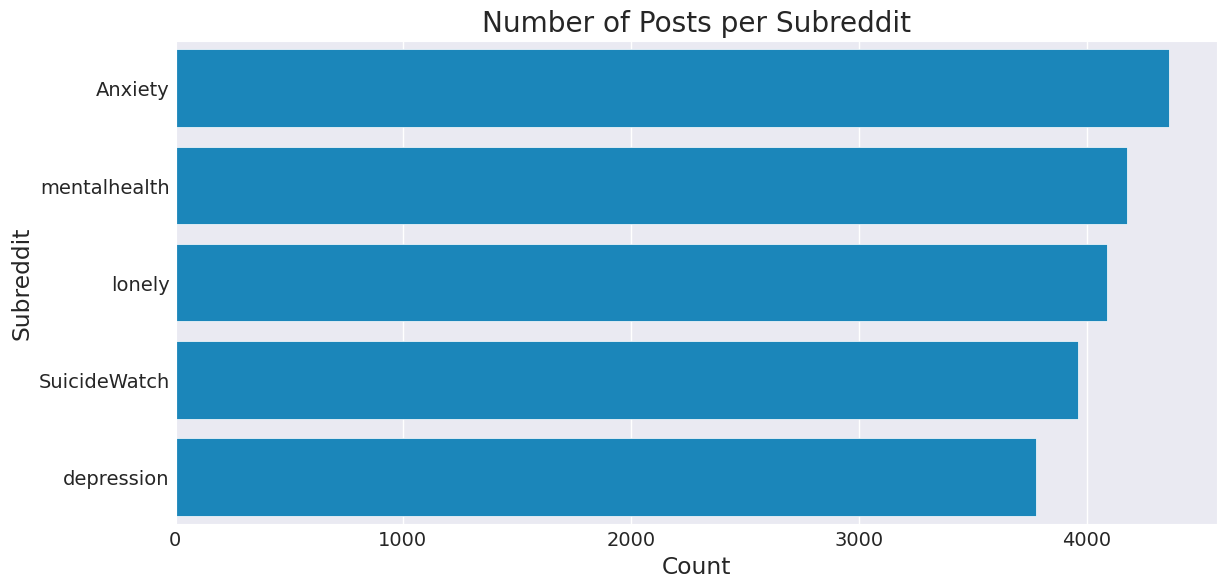

In [154]:
# Posts per subreddit
plt.figure(figsize=(12, 6))
sns.countplot(y='subreddit', data=df, order=df['subreddit'].value_counts().index)
plt.title('Number of Posts per Subreddit')
plt.xlabel('Count')
plt.ylabel('Subreddit')
plt.show()

In [155]:
posts_per_month = df.groupby('year_month').size().reset_index(name='count')
posts_per_month['year_month'] = pd.to_datetime(posts_per_month['year_month'], format='%Y-%m')
posts_per_month = posts_per_month.sort_values('year_month')

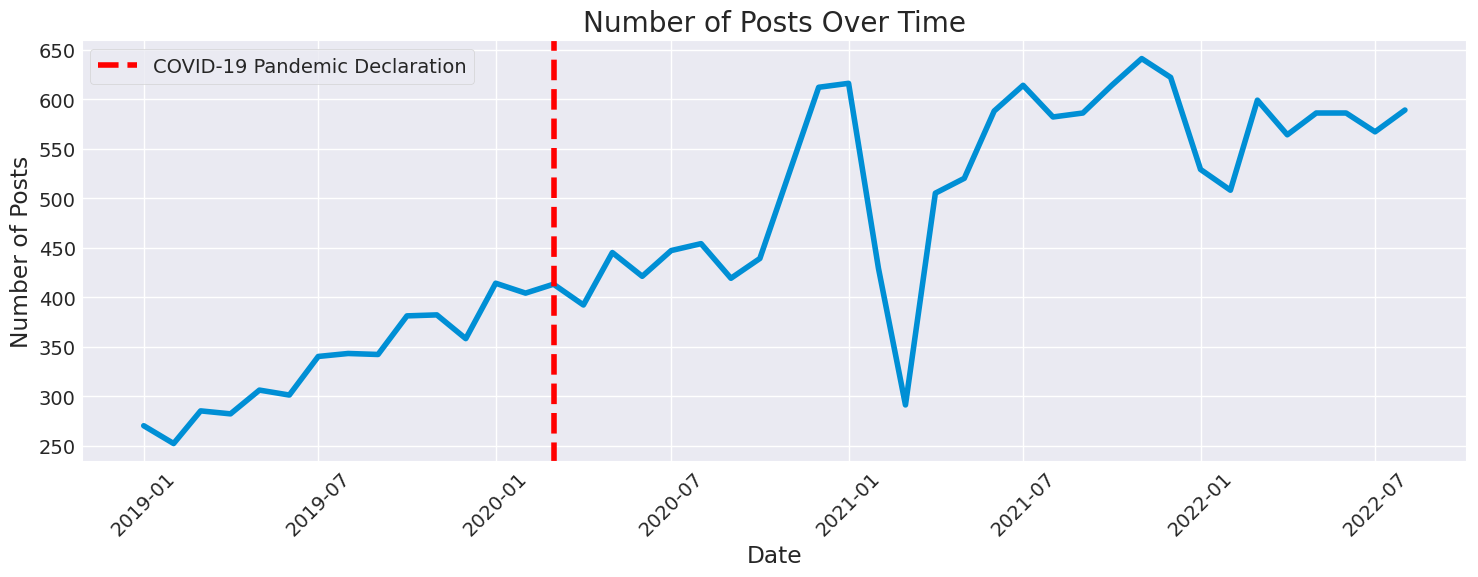

In [156]:
plt.figure(figsize=(15, 6))
plt.plot(posts_per_month['year_month'], posts_per_month['count'])
plt.title('Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2020-03-01'), color='r', linestyle='--', 
            label='COVID-19 Pandemic Declaration')
plt.legend()
plt.tight_layout()
plt.show()

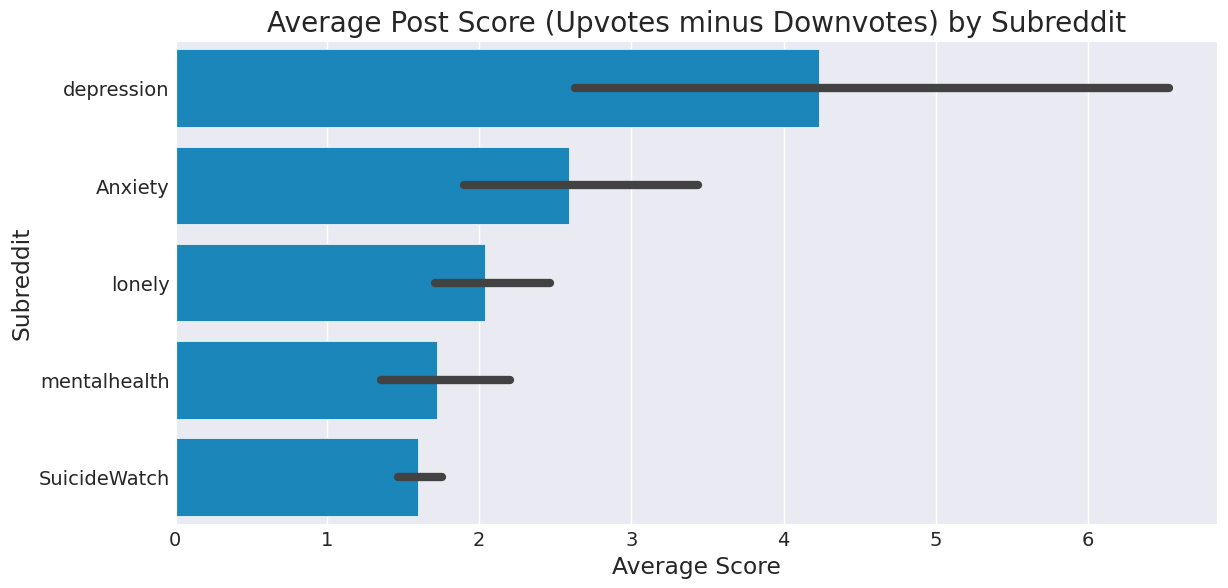

In [157]:
plt.figure(figsize=(12, 6))
sns.barplot(y='subreddit', x='score', data=df, estimator=np.mean, 
            order=df.groupby('subreddit')['score'].mean().sort_values(ascending=False).index)
plt.title('Average Post Score (Upvotes minus Downvotes) by Subreddit')
plt.xlabel('Average Score')
plt.ylabel('Subreddit')
plt.show()

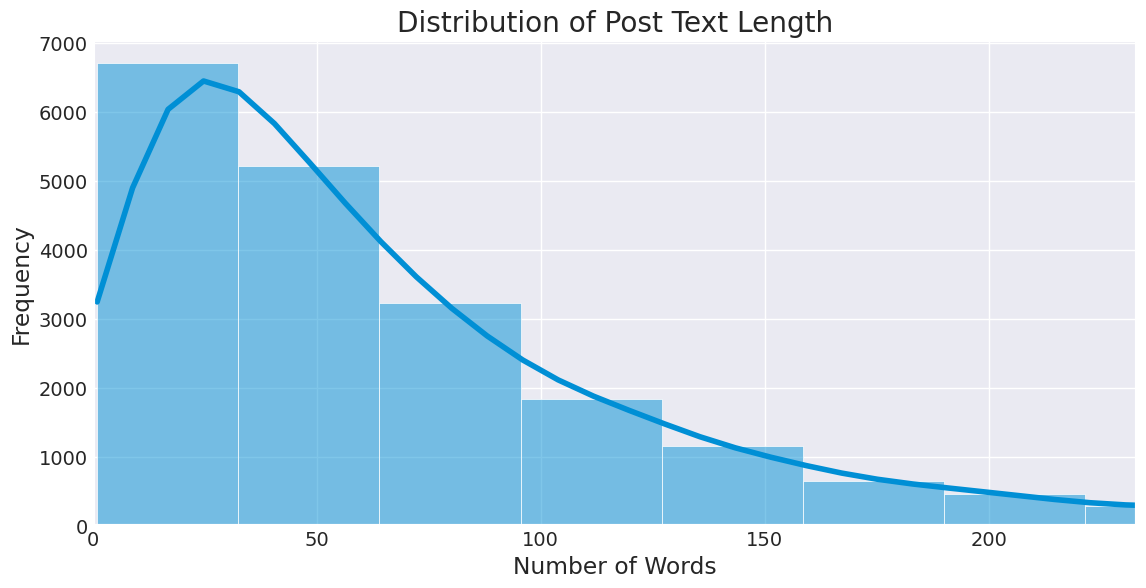

In [158]:
# Text length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['text_word_count'], bins=50, kde=True)
plt.title('Distribution of Post Text Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, df['text_word_count'].quantile(0.95)) 
plt.show()

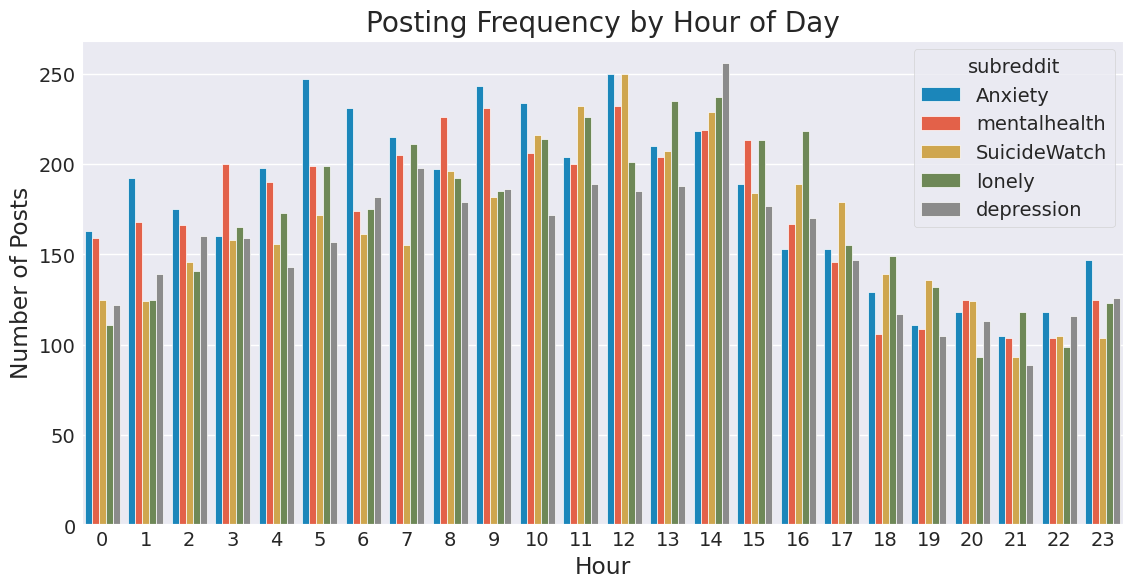

In [159]:
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=df, hue='subreddit')
plt.title('Posting Frequency by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Posts')
plt.show()

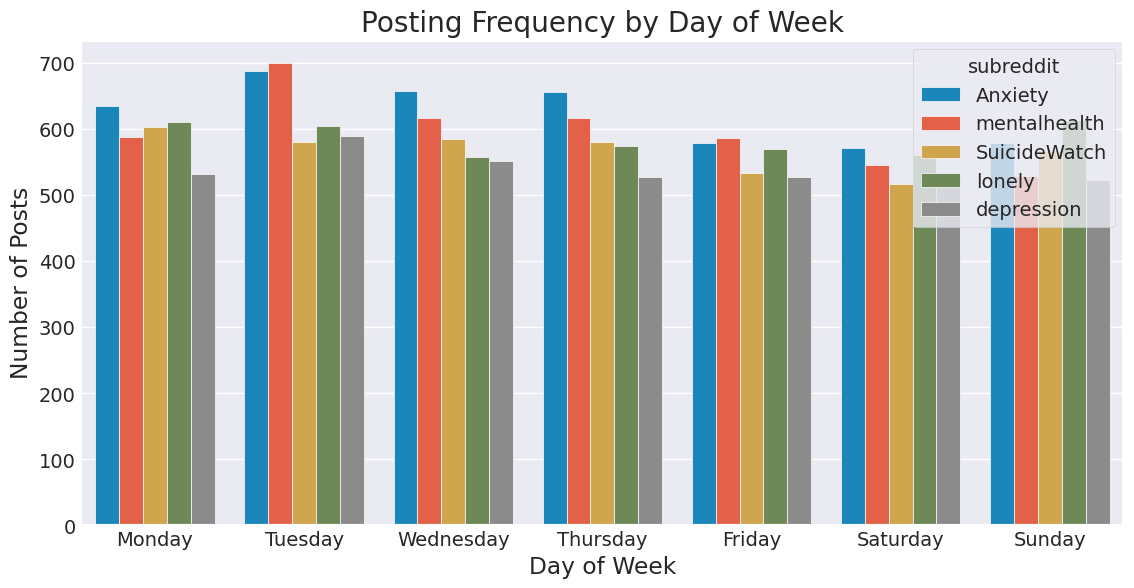

In [160]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.countplot(x='day_of_week', data=df, hue='subreddit')
plt.title('Posting Frequency by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Posts')
plt.xticks(ticks=range(7), labels=days)
plt.show()

## 3. Feature Engineering


### 3.1 Sentiment Analysis

In [161]:
sia = SentimentIntensityAnalyzer()
def get_sentiment_scores(text):
    if pd.isna(text) or text == '':
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    return sia.polarity_scores(text)

In [162]:
df['title_sentiment'] = df['title'].apply(lambda x: get_sentiment_scores(str(x))['compound'])
df['text_sentiment'] = df['text'].apply(lambda x: get_sentiment_scores(str(x))['compound'])
df['overall_sentiment'] = (df['title_sentiment'] + df['text_sentiment']) / 2

In [163]:
df['textblob_sentiment'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['textblob_subjectivity'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

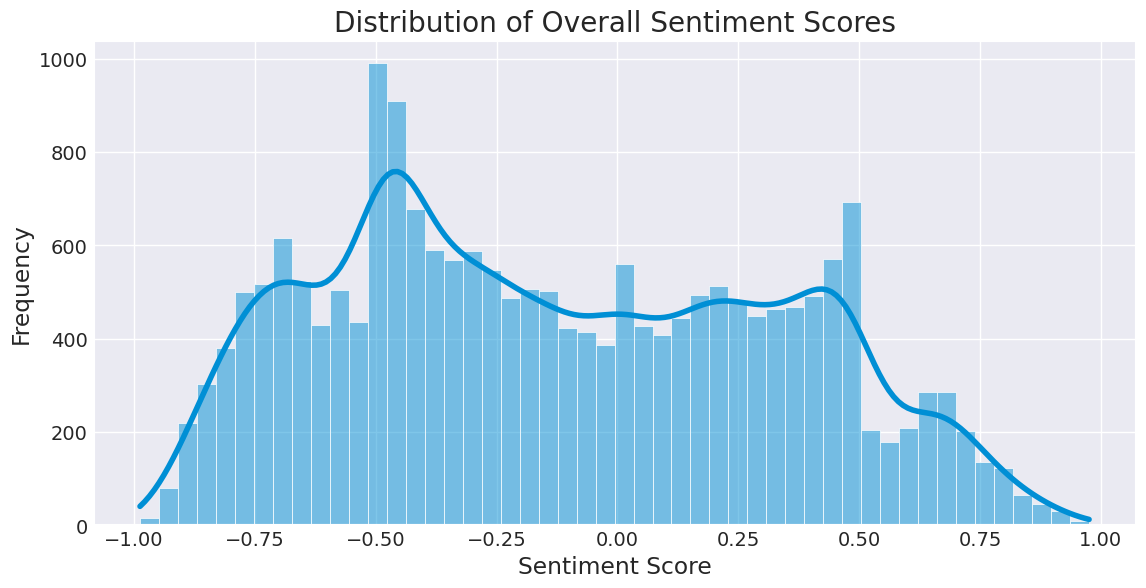

In [164]:
plt.figure(figsize=(12, 6))
sns.histplot(df['overall_sentiment'], bins=50, kde=True)
plt.title('Distribution of Overall Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

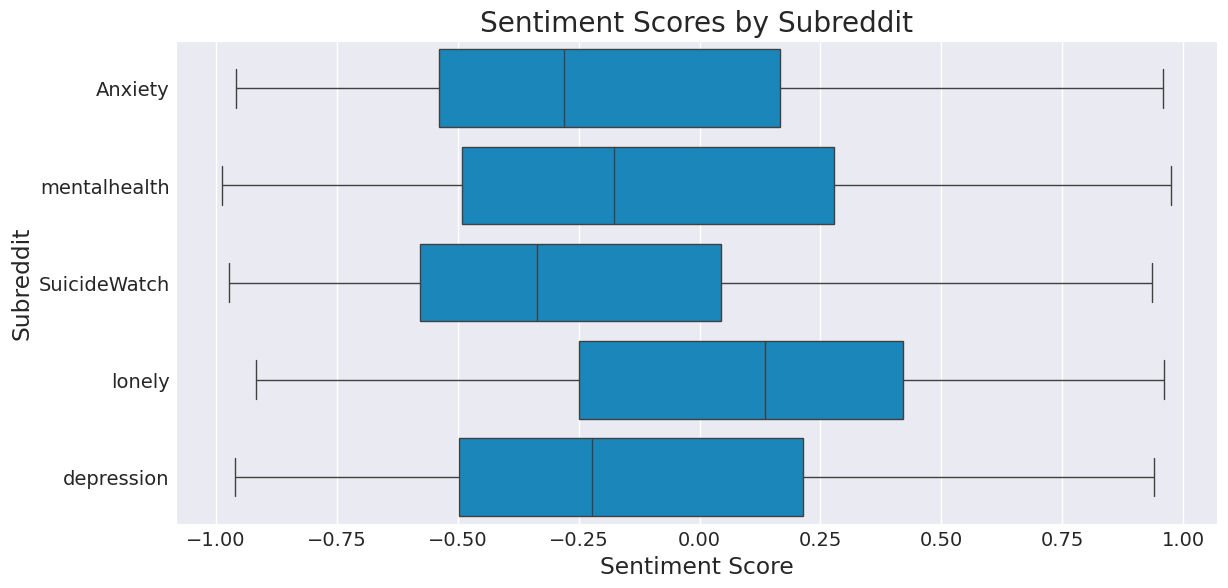

In [165]:
# Sentiment by subreddit
plt.figure(figsize=(12, 6))
sns.boxplot(y='subreddit', x='overall_sentiment', data=df)
plt.title('Sentiment Scores by Subreddit')
plt.xlabel('Sentiment Score')
plt.ylabel('Subreddit')
plt.show()

### 3.2 Emotion Analysis

In [166]:
lexicon = Empath()
mental_health_categories = ['negative_emotion', 'positive_emotion', 'sadness', 'fear', 'death', 'suffering', 'pain', 'shame', 'violence', 'love', 'optimism']

In [167]:
def analyze_emotions(text):
    if pd.isna(text) or text == '':
        return {cat: 0 for cat in mental_health_categories}
    
    analysis = lexicon.analyze(text, categories=mental_health_categories, normalize=True)
    return analysis

In [168]:
emotion_analyses = df['text'].apply(analyze_emotions)

In [169]:
for category in mental_health_categories:
    df[category] = emotion_analyses.apply(lambda x: x[category])

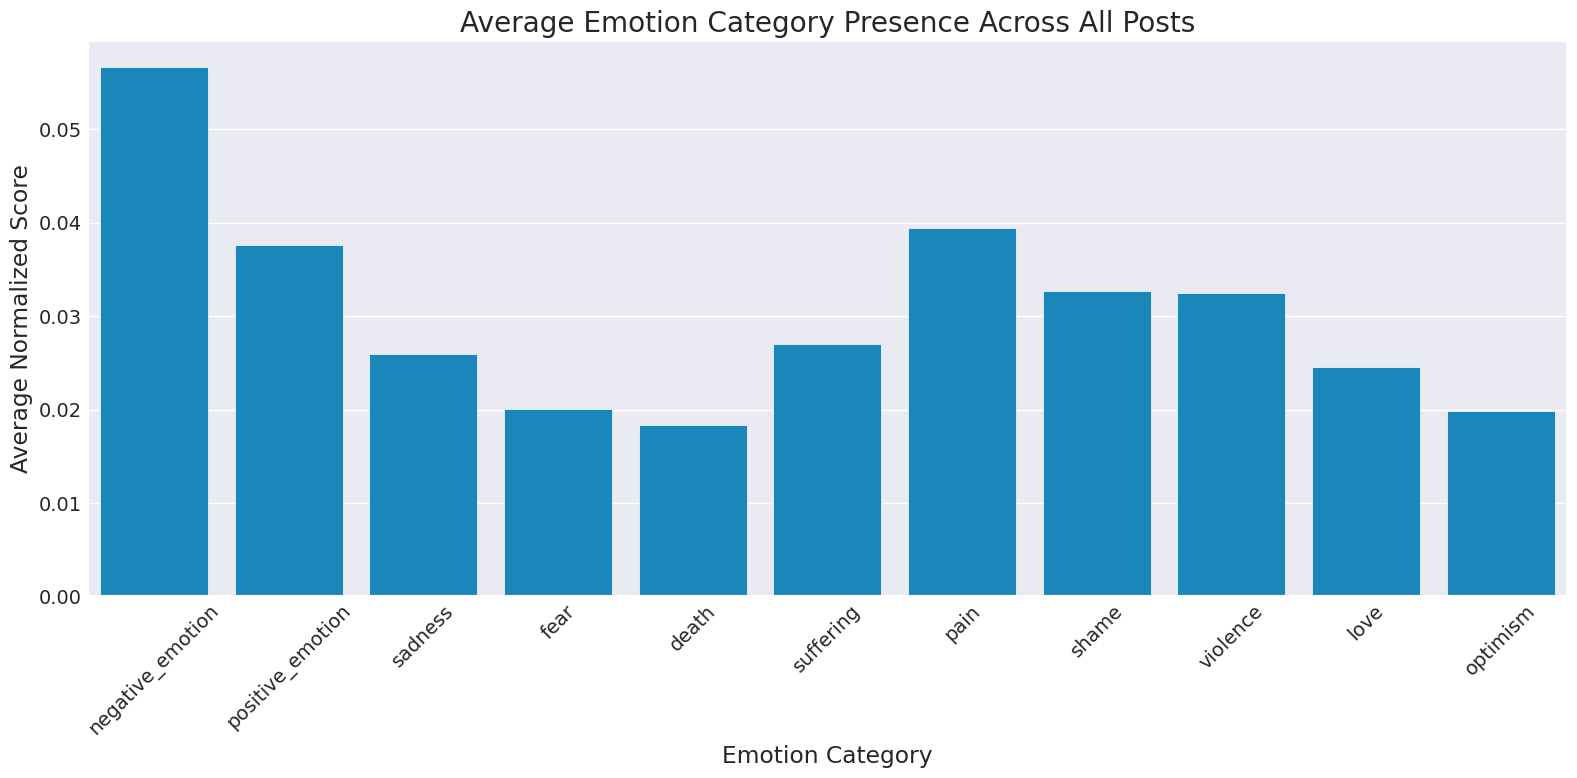

In [170]:
plt.figure(figsize=(16, 8))
emotion_means = [df[category].mean() for category in mental_health_categories]
sns.barplot(x=mental_health_categories, y=emotion_means)
plt.title('Average Emotion Category Presence Across All Posts')
plt.xlabel('Emotion Category')
plt.ylabel('Average Normalized Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [171]:
emotion_by_subreddit = pd.DataFrame()
for category in mental_health_categories:
    for subreddit in df['subreddit'].unique():
        emotion_by_subreddit.loc[subreddit, category] = df[df['subreddit'] == subreddit][category].mean()

<Figure size 1600x1000 with 0 Axes>

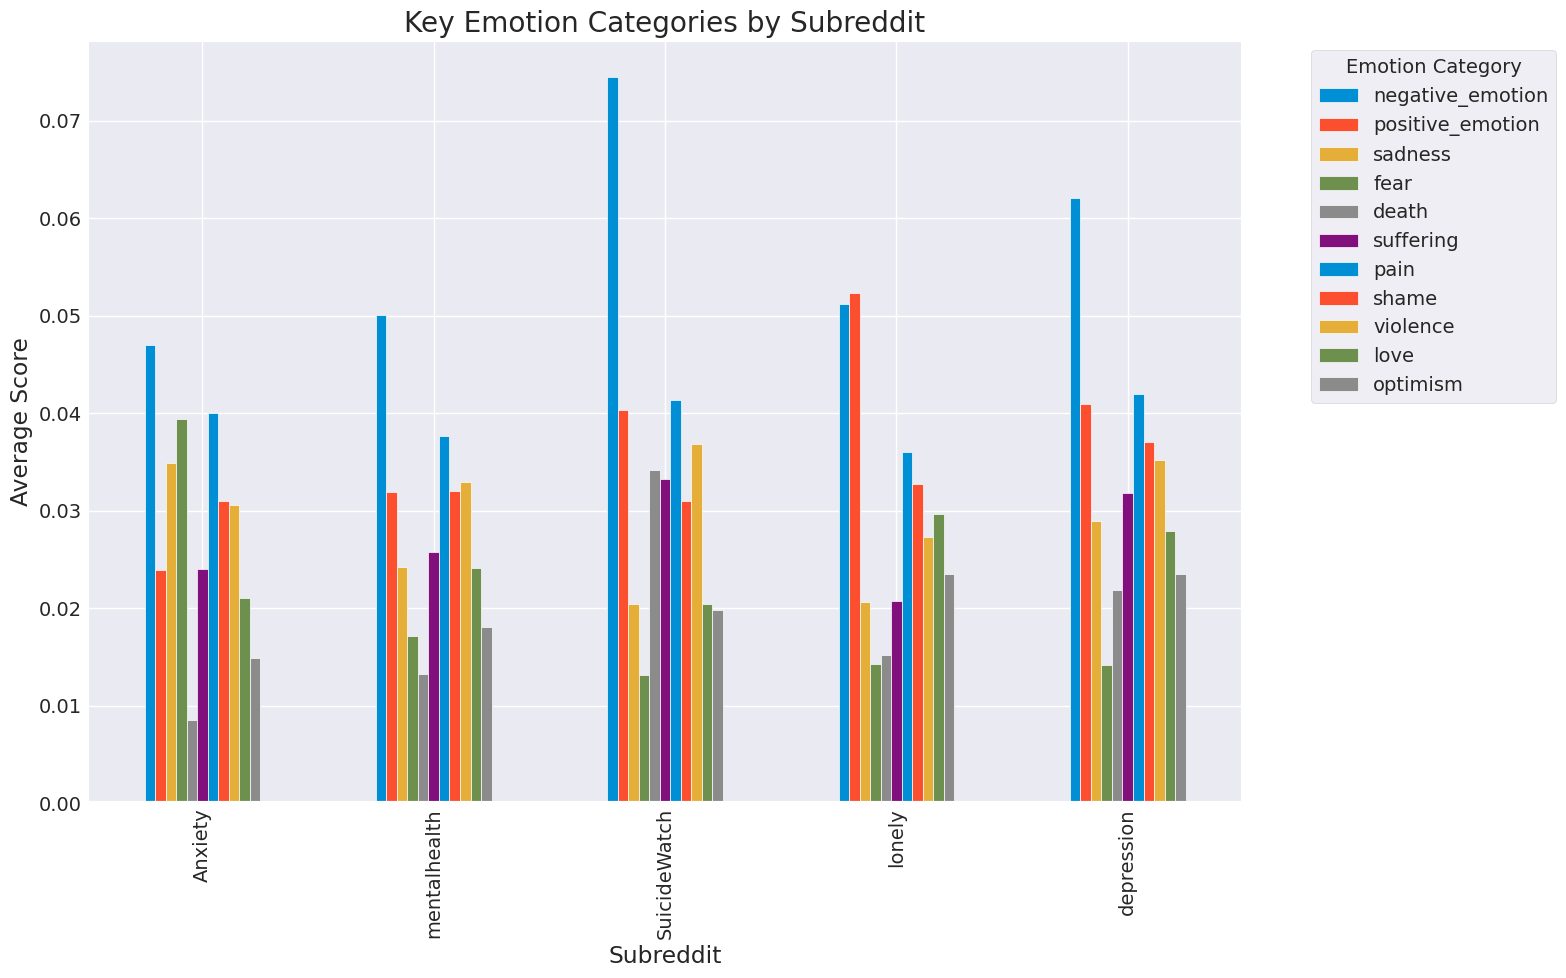

In [ ]:
plt.figure(figsize=(16, 10))
emotion_by_subreddit[mental_health_categories].plot(kind='bar', figsize=(16, 10))
plt.title('Key Emotion Categories by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Score')
plt.legend(title='Emotion Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

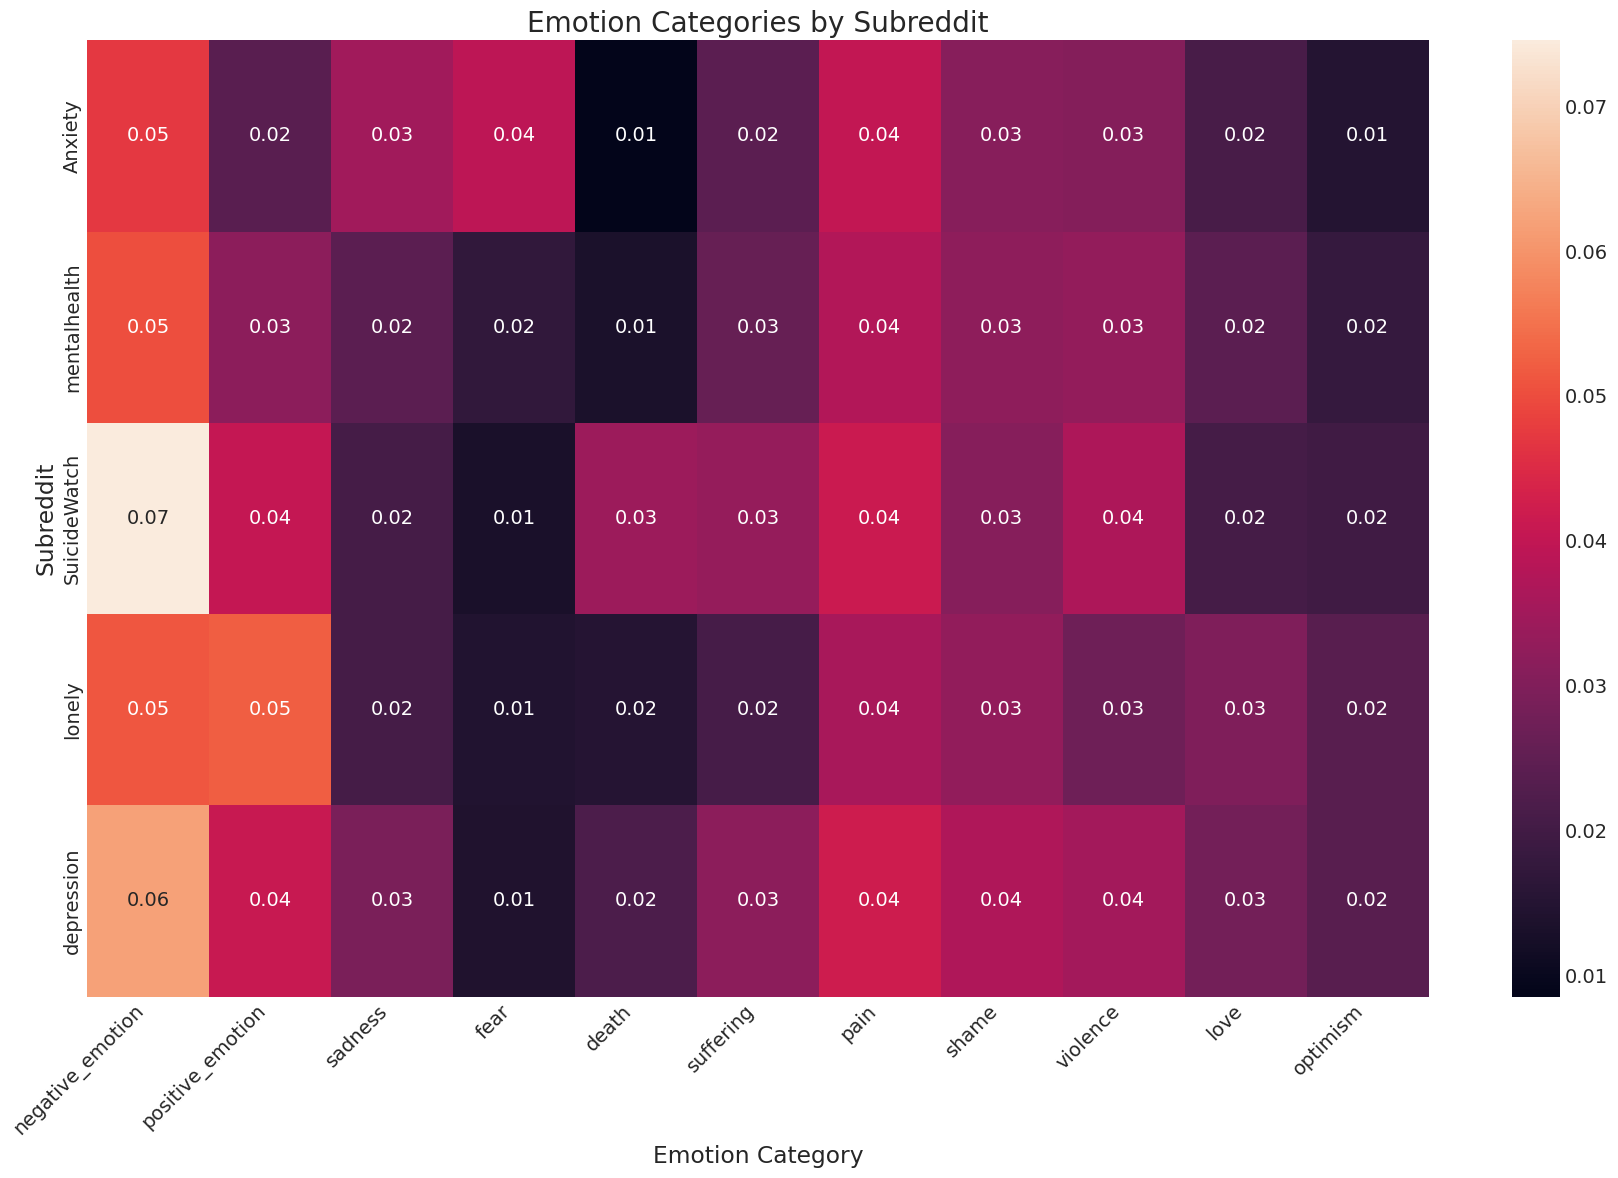

In [174]:
plt.figure(figsize=(18, 12))
sns.heatmap(emotion_by_subreddit, cmap='rocket', annot=True, fmt='.2f')
plt.title('Emotion Categories by Subreddit')
plt.ylabel('Subreddit')
plt.xlabel('Emotion Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 3.3 Topic Modeling

In [175]:
def preprocess_for_topics(text):
    text = str(text).lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and len(word) > 2]
    
    return tokens

In [176]:
df['tokens'] = df['text'].apply(preprocess_for_topics)

In [177]:
df = df[df['tokens'].map(len) > 0].reset_index(drop=True)

In [178]:
id2word = Dictionary(df['tokens'])
corpus = [id2word.doc2bow(text) for text in df['tokens']]

In [179]:
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=10,
    random_state=42,
    passes=10,
    workers=4
)

In [180]:
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}')

Topic: 0 
Words: 0.018*"get" + 0.014*"job" + 0.013*"work" + 0.011*"day" + 0.010*"know" + 0.008*"time" + 0.008*"going" + 0.008*"like" + 0.007*"help" + 0.007*"need"
Topic: 1 
Words: 0.021*"anxiety" + 0.011*"feel" + 0.010*"like" + 0.009*"time" + 0.008*"thought" + 0.007*"ive" + 0.007*"year" + 0.007*"get" + 0.007*"day" + 0.006*"thing"
Topic: 2 
Words: 0.024*"friend" + 0.011*"time" + 0.011*"year" + 0.010*"really" + 0.009*"know" + 0.009*"like" + 0.009*"dont" + 0.009*"one" + 0.009*"talk" + 0.008*"want"
Topic: 3 
Words: 0.013*"people" + 0.010*"like" + 0.009*"help" + 0.006*"mental" + 0.006*"get" + 0.006*"would" + 0.006*"please" + 0.005*"music" + 0.005*"need" + 0.005*"feel"
Topic: 4 
Words: 0.011*"like" + 0.009*"school" + 0.009*"get" + 0.009*"mom" + 0.008*"would" + 0.008*"time" + 0.008*"even" + 0.007*"dad" + 0.007*"one" + 0.006*"year"
Topic: 5 
Words: 0.018*"want" + 0.011*"life" + 0.010*"know" + 0.010*"like" + 0.009*"feel" + 0.009*"pain" + 0.008*"hate" + 0.008*"time" + 0.008*"fucking" + 0.007*"re

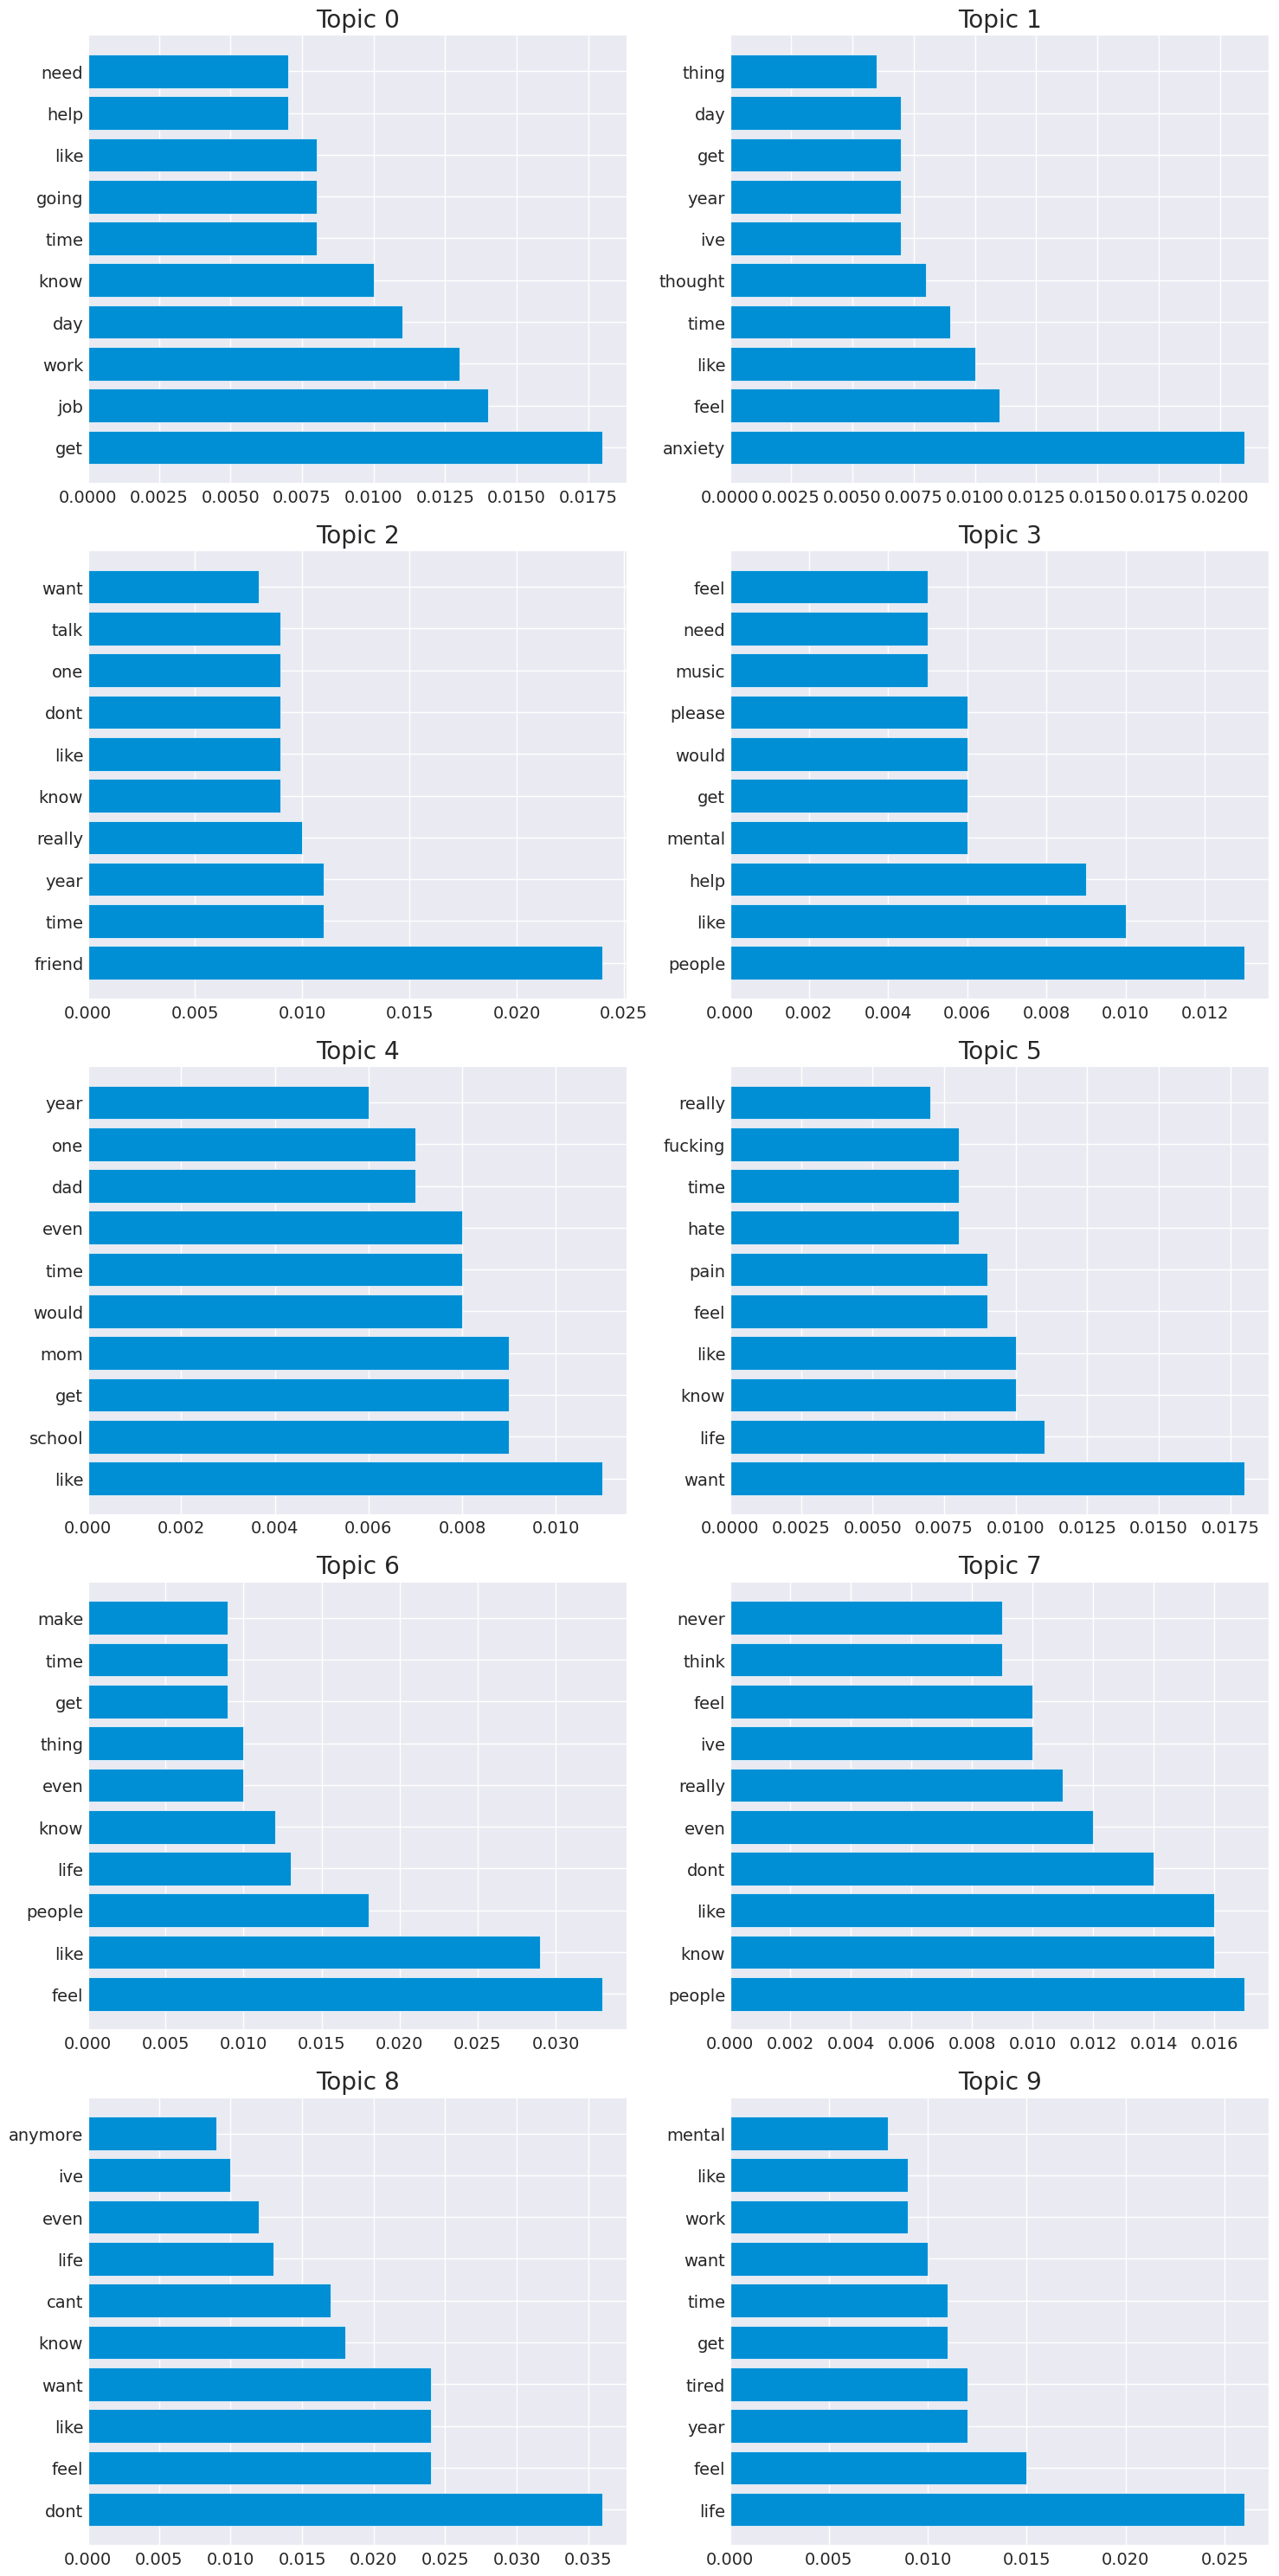

In [198]:
plt.figure(figsize=(15, 30))
for i, topic in enumerate(lda_model.print_topics()):
    plt.subplot(5, 2, i+1)
    
    words_weights = re.findall(r'(\d+\.\d+)\*"(\w+)"', str(topic[1]))
    words = [w[1] for w in words_weights]
    weights = [float(w[0]) for w in words_weights]

    y_pos = range(len(words))
    plt.barh(y_pos, weights)
    plt.yticks(y_pos, words)
    plt.title(f'Topic {i}')

plt.tight_layout()
plt.show()

In [199]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df._append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return sent_topics_df

In [200]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['text'])

In [201]:
df['dominant_topic'] = df_topic_sents_keywords['Dominant_Topic']
df['topic_contribution'] = df_topic_sents_keywords['Perc_Contribution']
df['topic_keywords'] = df_topic_sents_keywords['Topic_Keywords']

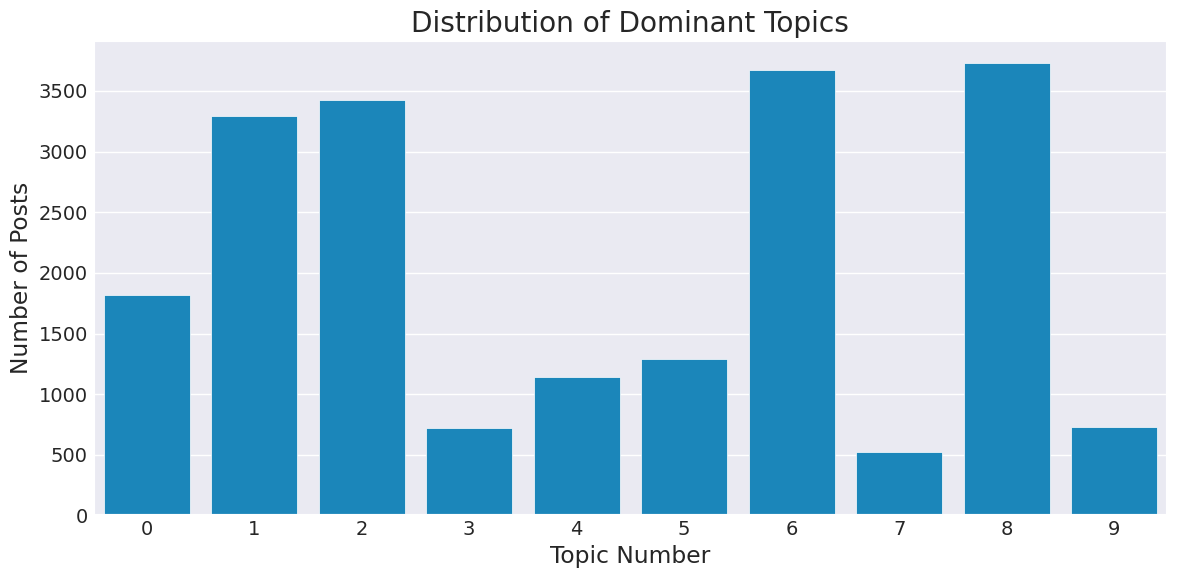

In [202]:
plt.figure(figsize=(12, 6))
topic_counts = df['dominant_topic'].value_counts().sort_index()
sns.barplot(x=topic_counts.index, y=topic_counts.values)
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topic Number')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

In [203]:
topic_by_subreddit = pd.crosstab(df['subreddit'], df['dominant_topic'])
topic_by_subreddit_norm = topic_by_subreddit.div(topic_by_subreddit.sum(axis=1), axis=0)

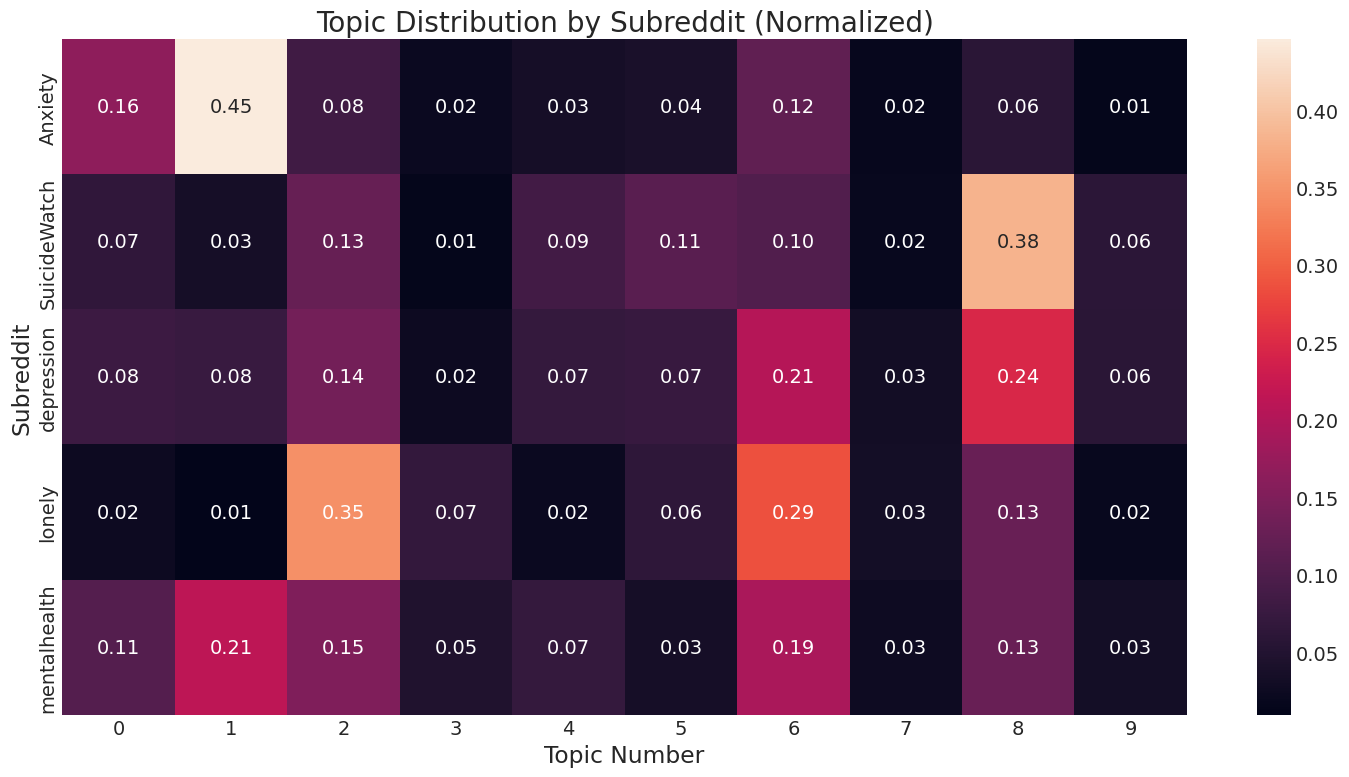

In [204]:
plt.figure(figsize=(15, 8))
sns.heatmap(topic_by_subreddit_norm, cmap='rocket', annot=True, fmt='.2f')
plt.title('Topic Distribution by Subreddit (Normalized)')
plt.xlabel('Topic Number')
plt.ylabel('Subreddit')
plt.tight_layout()
plt.show()

### 3.4 Word Frequency Analysis

In [205]:
def get_top_words(texts, n=20):
    words = []
    for text in texts:
        text = str(text).lower()
        words.extend([word for word in re.findall(r'\b[a-z]+\b', text) if len(word) > 2])
    
    word_counts = Counter(words)
    return word_counts.most_common(n)

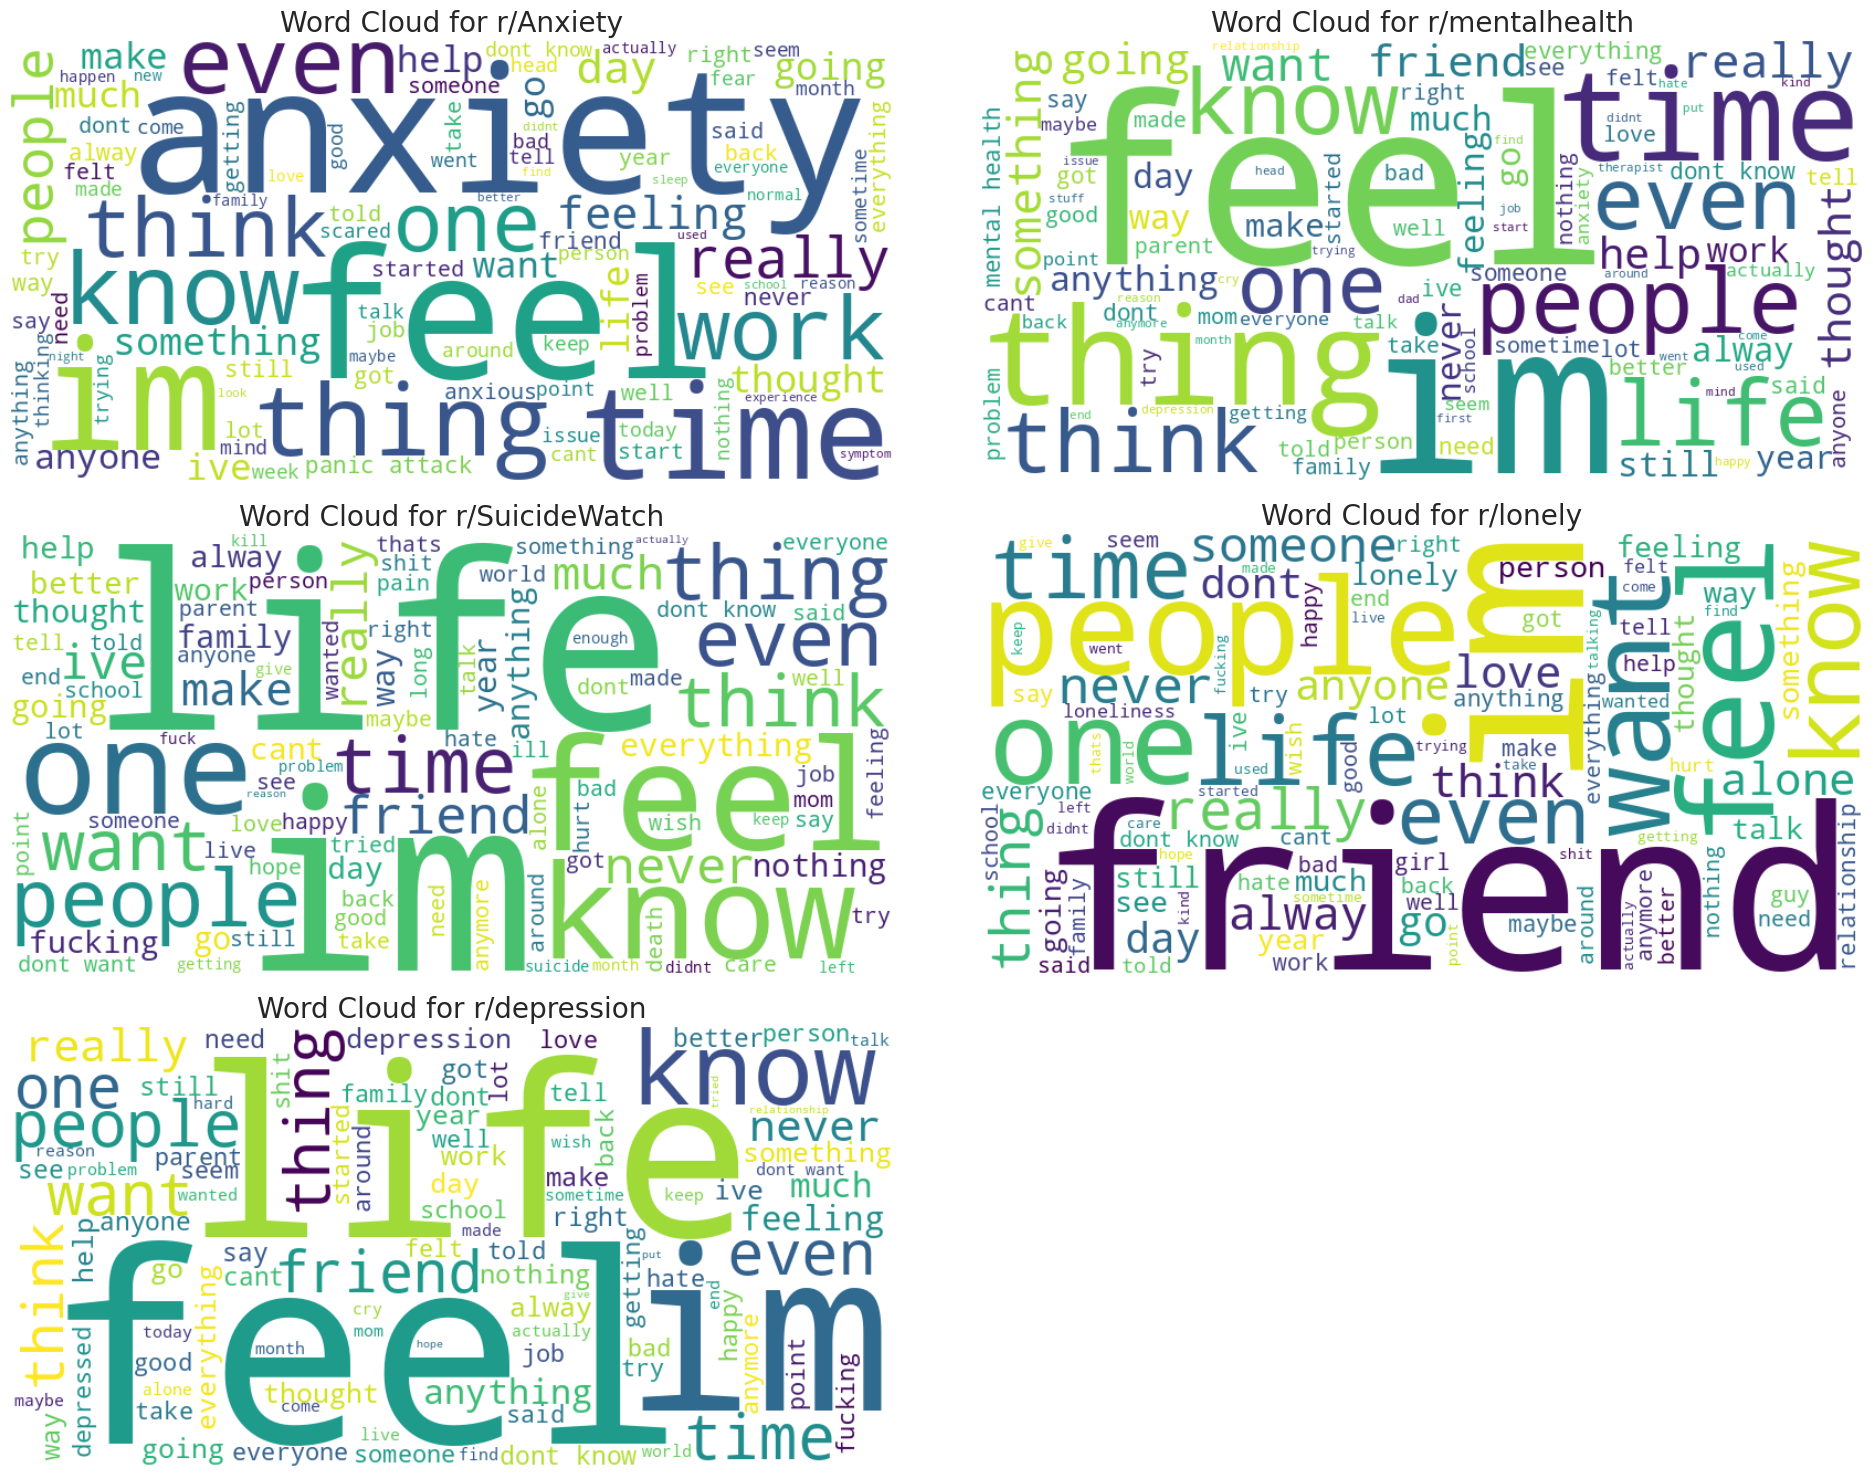

In [206]:
subreddits = df['subreddit'].unique()
plt.figure(figsize=(20, 15))

for i, subreddit in enumerate(subreddits):
    plt.subplot(3, 2, i+1)

    texts = df[df['subreddit'] == subreddit]['text'].values
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         max_words=100, contour_width=3, contour_color='steelblue').generate(' '.join(map(str, texts)))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for r/{subreddit}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### TF-IDF Analysis

In [208]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.7)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'].astype(str))

In [209]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [210]:
def get_top_tfidf_words(tfidf_matrix, feature_names, subreddit_indices, n=10):
    subreddit_tfidf = tfidf_matrix[subreddit_indices].mean(axis=0)

    subreddit_tfidf = np.asarray(subreddit_tfidf).flatten()
    top_indices = subreddit_tfidf.argsort()[-n:][::-1]

    top_words = [(feature_names[i], subreddit_tfidf[i]) for i in top_indices]
    
    return top_words


Top distinctive words for r/Anxiety:
anxiety: 0.0935
like: 0.0547
feel: 0.0535
im: 0.0520
get: 0.0431
know: 0.0361
anxious: 0.0352
really: 0.0344
time: 0.0340
day: 0.0333


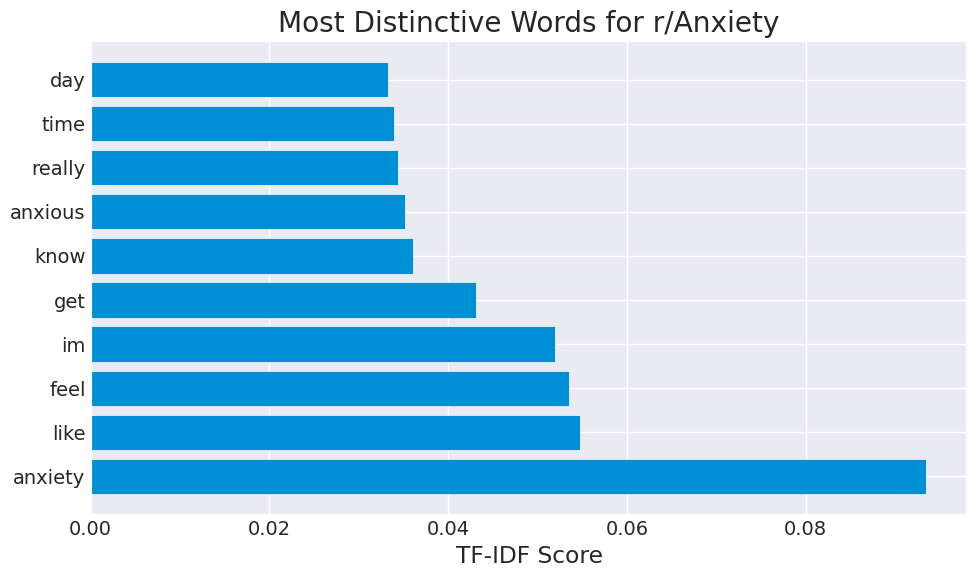


Top distinctive words for r/mentalhealth:
im: 0.0626
like: 0.0616
feel: 0.0598
know: 0.0461
dont: 0.0420
get: 0.0403
time: 0.0381
want: 0.0377
really: 0.0373
thing: 0.0355


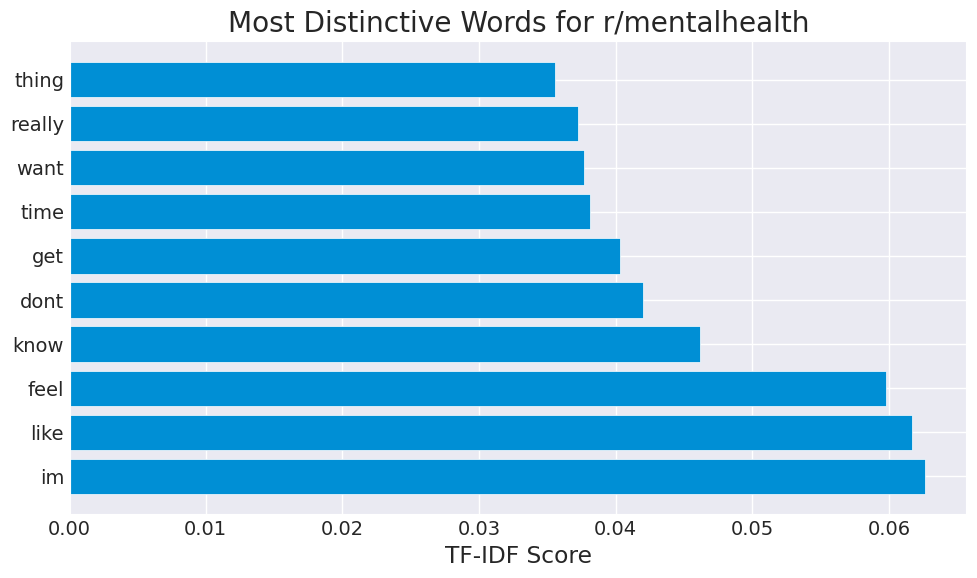


Top distinctive words for r/SuicideWatch:
im: 0.0757
want: 0.0587
life: 0.0516
dont: 0.0508
like: 0.0437
feel: 0.0425
know: 0.0397
get: 0.0326
die: 0.0315
even: 0.0315


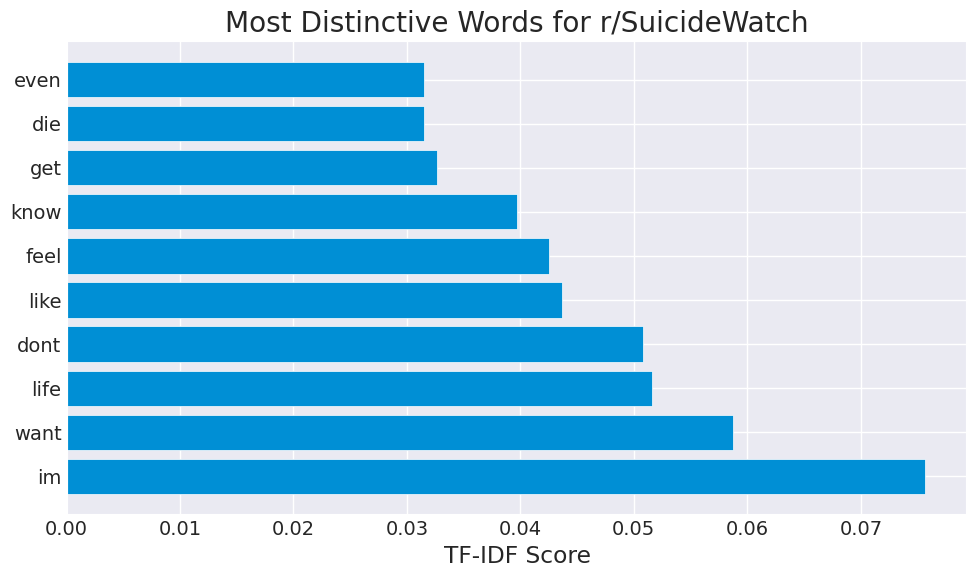


Top distinctive words for r/lonely:
friend: 0.0688
im: 0.0575
feel: 0.0500
like: 0.0500
people: 0.0494
talk: 0.0466
lonely: 0.0465
someone: 0.0439
want: 0.0414
alone: 0.0383


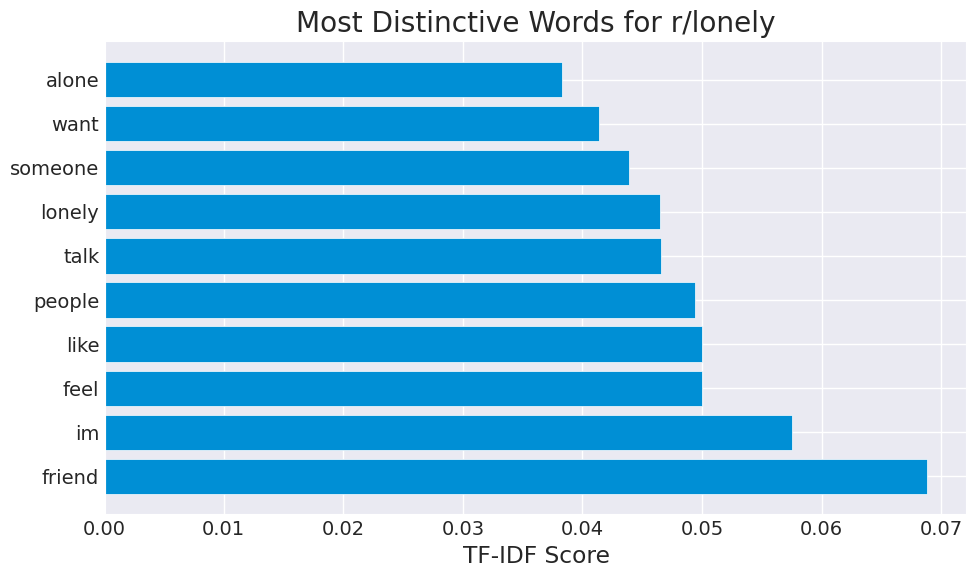


Top distinctive words for r/depression:
im: 0.0655
feel: 0.0647
like: 0.0578
dont: 0.0481
want: 0.0465
life: 0.0456
know: 0.0428
get: 0.0379
depression: 0.0355
time: 0.0352


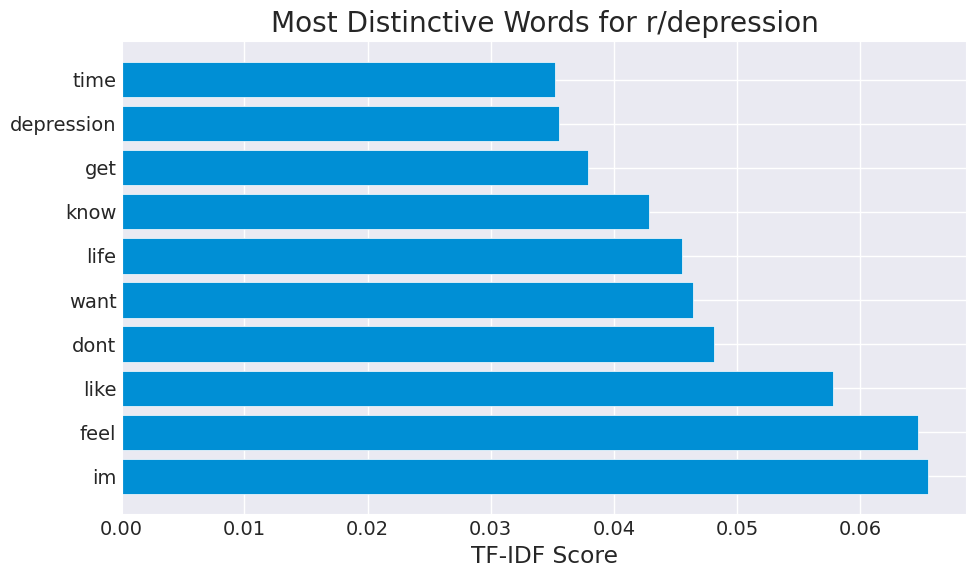

In [211]:
for subreddit in subreddits:
    subreddit_indices = df[df['subreddit'] == subreddit].index
    top_words = get_top_tfidf_words(tfidf_matrix, tfidf_feature_names, subreddit_indices)
    
    print(f"\nTop distinctive words for r/{subreddit}:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")

    plt.figure(figsize=(10, 6))
    words, scores = zip(*top_words)
    plt.barh(range(len(words)), scores, align='center')
    plt.yticks(range(len(words)), words)
    plt.xlabel('TF-IDF Score')
    plt.title(f'Most Distinctive Words for r/{subreddit}')
    plt.tight_layout()
    plt.show()

In [217]:
df['distress_score'] = (
    df['negative_emotion'] + 
    df['sadness'] + 
    df['fear'] + 
    df['death'] + 
    df['suffering'] + 
    df['pain'] +
    df['shame'] +
    df['violence'] - 
    df['positive_emotion'] - 
    df['love'] - 
    df['optimism'] -
    df['overall_sentiment']
)

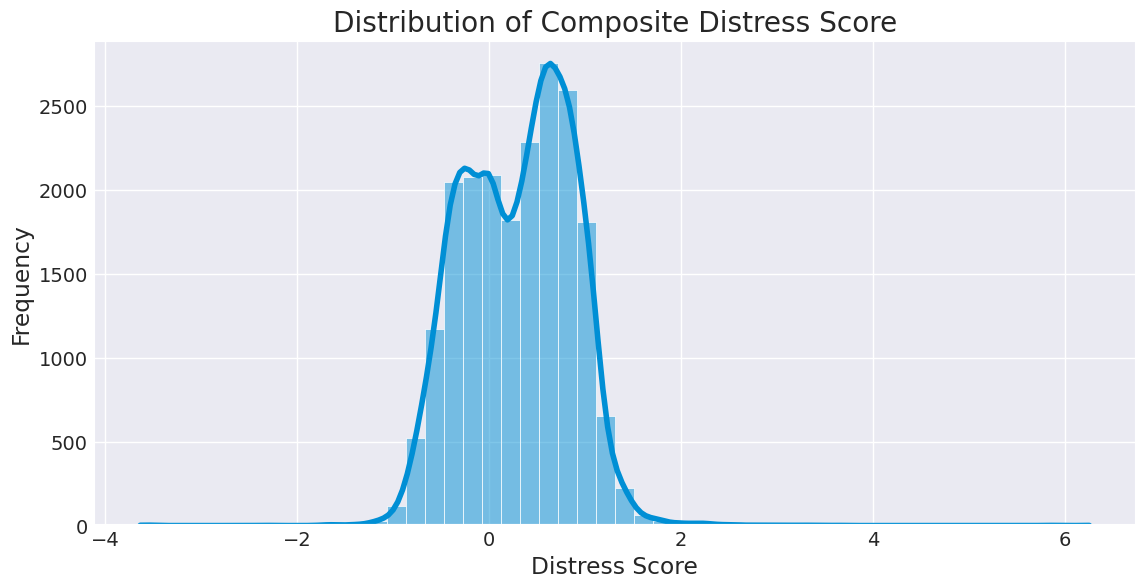

In [218]:
plt.figure(figsize=(12, 6))
sns.histplot(df['distress_score'], bins=50, kde=True)
plt.title('Distribution of Composite Distress Score')
plt.xlabel('Distress Score')
plt.ylabel('Frequency')
plt.show()

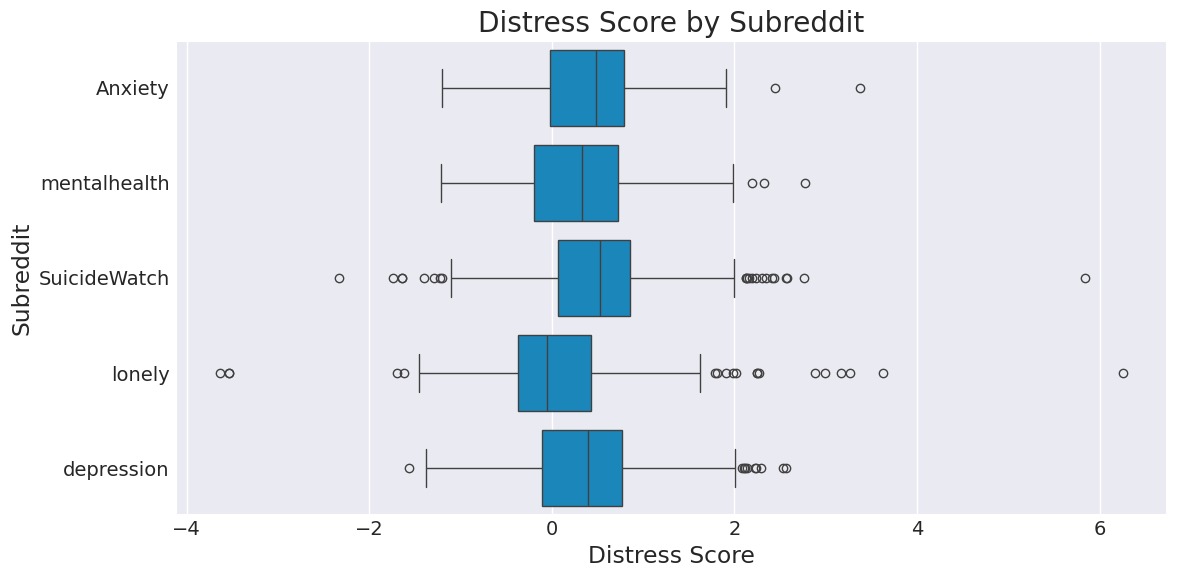

In [219]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='subreddit', x='distress_score', data=df)
plt.title('Distress Score by Subreddit')
plt.xlabel('Distress Score')
plt.ylabel('Subreddit')
plt.tight_layout()
plt.show()

## 4. Temporal Analysis and Impact of COVID-19

In [220]:
subreddit_time = df.groupby(['year_month', 'subreddit']).size().unstack().fillna(0)
subreddit_time.index = pd.to_datetime(subreddit_time.index, format='%Y-%m')
subreddit_time = subreddit_time.sort_index()

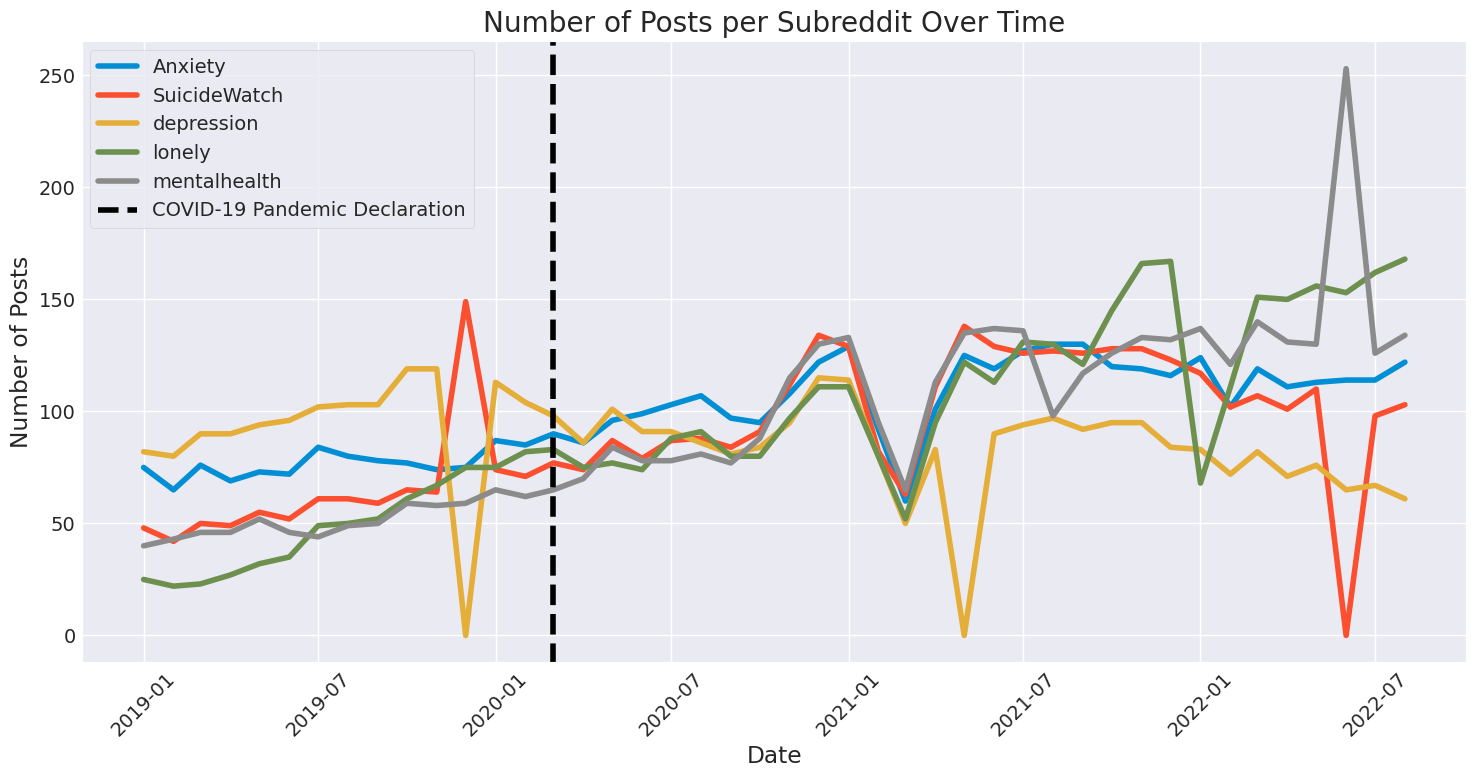

In [221]:
plt.figure(figsize=(15, 8))
for subreddit in subreddit_time.columns:
    plt.plot(subreddit_time.index, subreddit_time[subreddit], label=subreddit)
plt.title('Number of Posts per Subreddit Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2020-03-01'), color='k', linestyle='--', 
            label='COVID-19 Pandemic Declaration')
plt.legend()
plt.tight_layout()
plt.show()

In [224]:
sentiment_time = df.groupby('year_month')['overall_sentiment'].mean().reset_index()
sentiment_time['year_month'] = pd.to_datetime(sentiment_time['year_month'], format='%Y-%m')
sentiment_time = sentiment_time.sort_values('year_month')

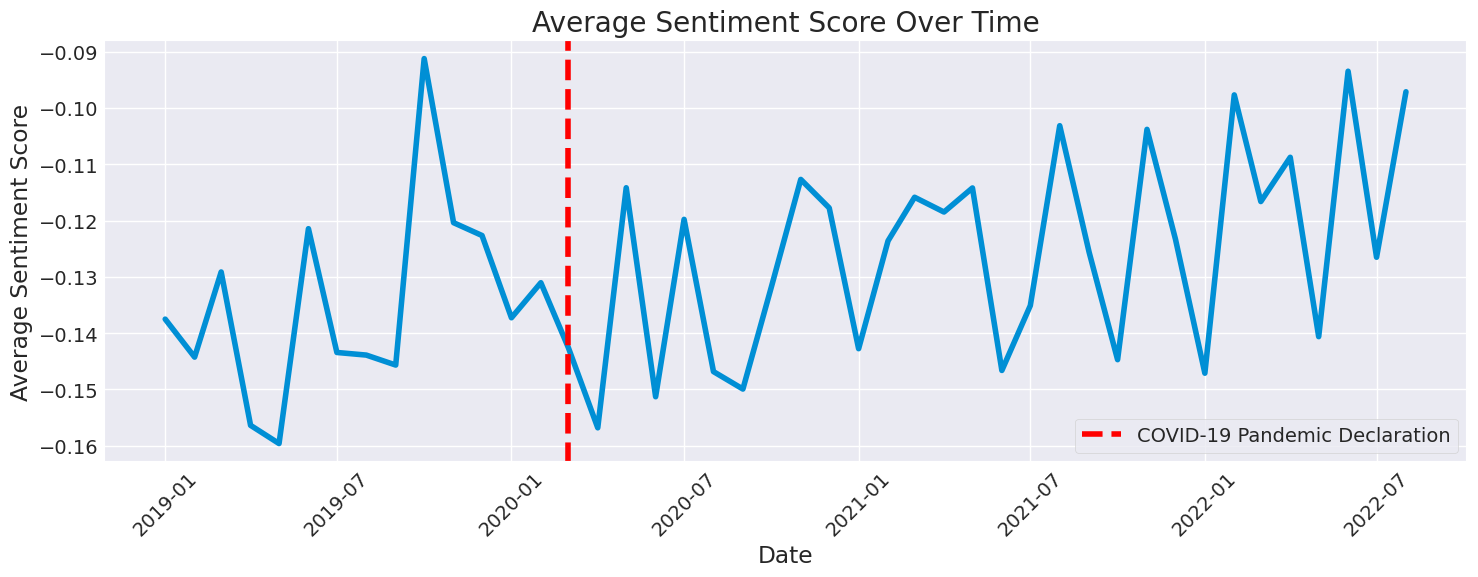

In [226]:
plt.figure(figsize=(15, 6))
plt.plot(sentiment_time['year_month'], sentiment_time['overall_sentiment'])
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2020-03-01'), color='r', linestyle='--', 
            label='COVID-19 Pandemic Declaration')
plt.legend()
plt.tight_layout()
plt.show()

In [227]:
subreddit_sentiment = df.groupby(['year_month', 'subreddit'])['overall_sentiment'].mean().unstack()
subreddit_sentiment.index = pd.to_datetime(subreddit_sentiment.index, format='%Y-%m')
subreddit_sentiment = subreddit_sentiment.sort_index()

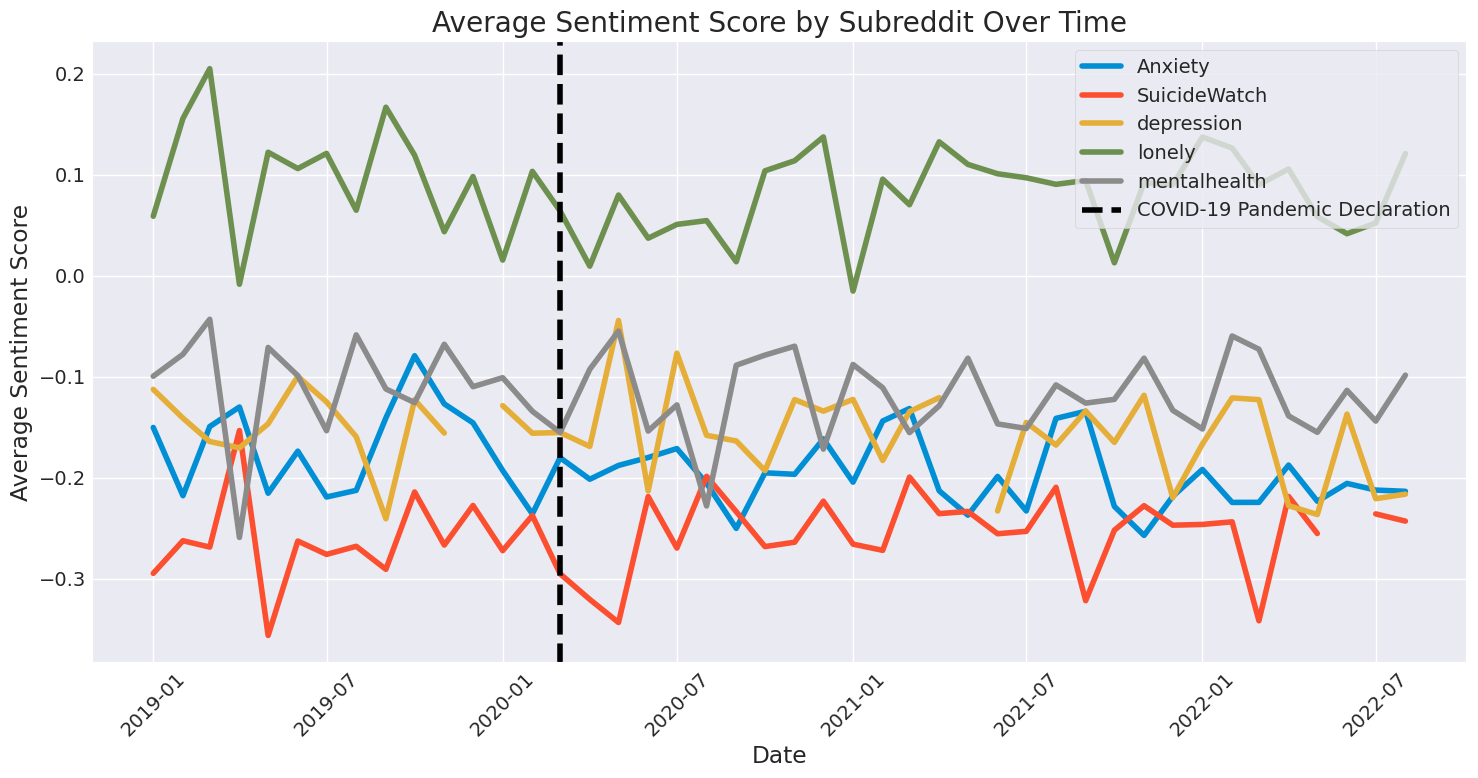

In [228]:
plt.figure(figsize=(15, 8))
for subreddit in subreddit_sentiment.columns:
    plt.plot(subreddit_sentiment.index, subreddit_sentiment[subreddit], label=subreddit)
plt.title('Average Sentiment Score by Subreddit Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2020-03-01'), color='k', linestyle='--', 
            label='COVID-19 Pandemic Declaration')
plt.legend()
plt.tight_layout()
plt.show()

In [229]:
emotion_time = {}
for emotion in mental_health_categories:
    emotion_time[emotion] = df.groupby('year_month')[emotion].mean()

emotion_time_df = pd.DataFrame(emotion_time)
emotion_time_df.index = pd.to_datetime(emotion_time_df.index, format='%Y-%m')
emotion_time_df = emotion_time_df.sort_index()

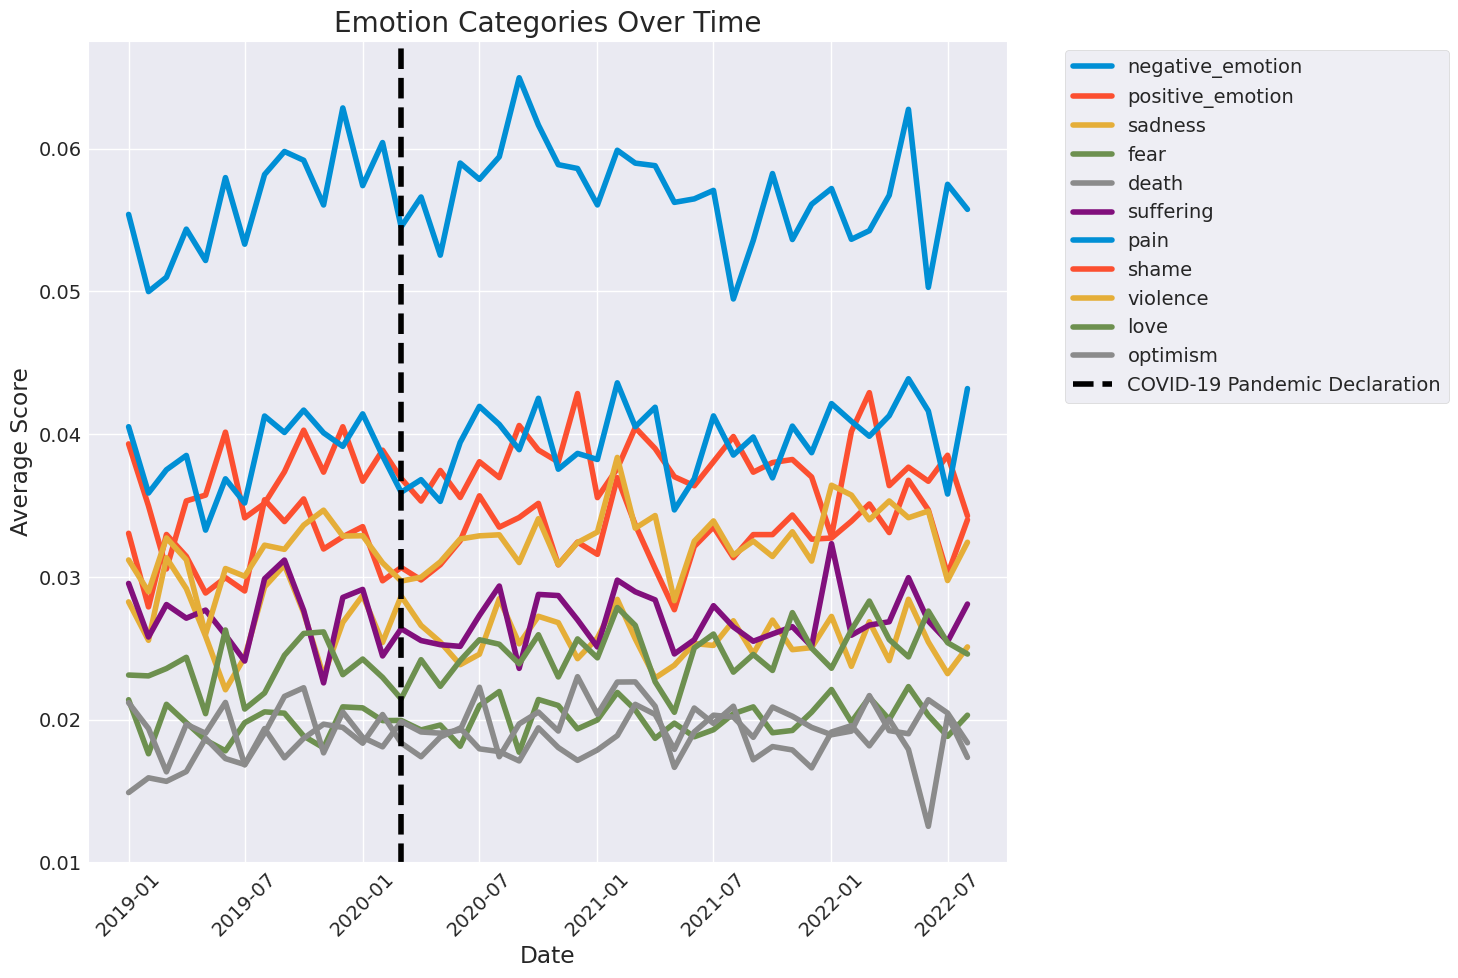

In [231]:
plt.figure(figsize=(15, 10))
for emotion in mental_health_categories:
    plt.plot(emotion_time_df.index, emotion_time_df[emotion], label=emotion)
plt.title('Emotion Categories Over Time')
plt.xlabel('Date')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2020-03-01'), color='k', linestyle='--', 
            label='COVID-19 Pandemic Declaration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [232]:
distress_time = df.groupby('year_month')['distress_score'].mean().reset_index()
distress_time['year_month'] = pd.to_datetime(distress_time['year_month'], format='%Y-%m')
distress_time = distress_time.sort_values('year_month')

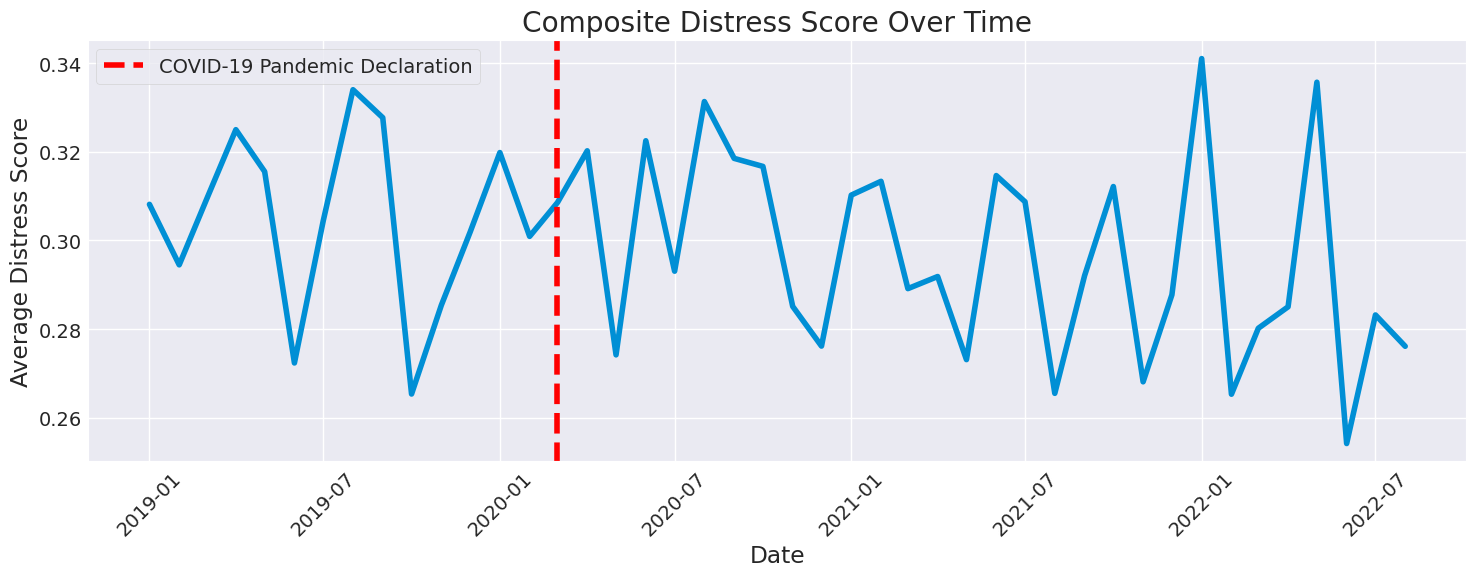

In [233]:
plt.figure(figsize=(15, 6))
plt.plot(distress_time['year_month'], distress_time['distress_score'])
plt.title('Composite Distress Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Distress Score')
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2020-03-01'), color='r', linestyle='--', 
            label='COVID-19 Pandemic Declaration')
plt.legend()
plt.tight_layout()
plt.show()

In [234]:
distress_subreddit_time = df.groupby(['year_month', 'subreddit'])['distress_score'].mean().unstack()
distress_subreddit_time.index = pd.to_datetime(distress_subreddit_time.index, format='%Y-%m')
distress_subreddit_time = distress_subreddit_time.sort_index()

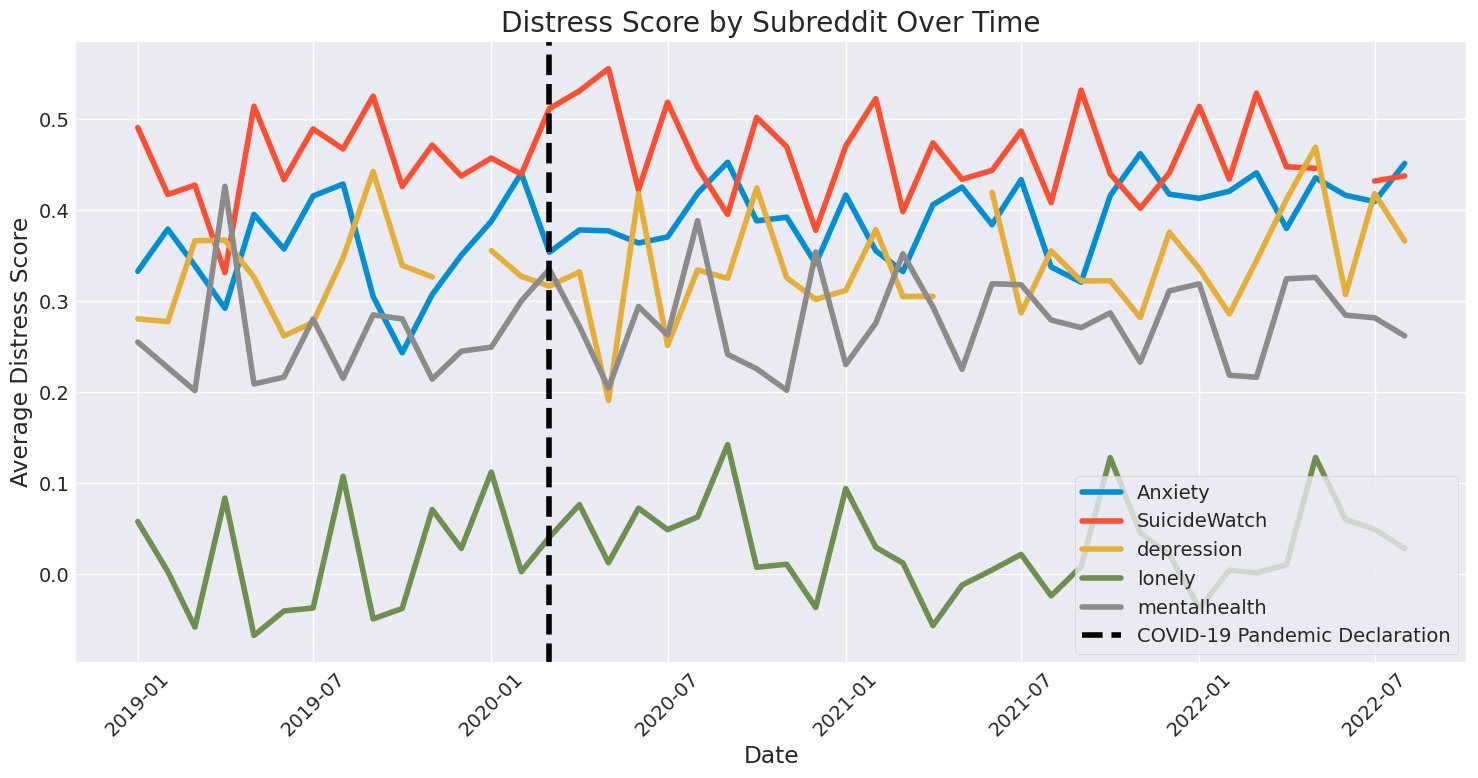

In [235]:
plt.figure(figsize=(15, 8))
for subreddit in distress_subreddit_time.columns:
    plt.plot(distress_subreddit_time.index, distress_subreddit_time[subreddit], label=subreddit)
plt.title('Distress Score by Subreddit Over Time')
plt.xlabel('Date')
plt.ylabel('Average Distress Score')
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2020-03-01'), color='k', linestyle='--', 
            label='COVID-19 Pandemic Declaration')
plt.legend()
plt.tight_layout()
plt.show()

In [239]:
pandemic_subreddit = pd.crosstab(df['subreddit'], df['pandemic_phase'])
pandemic_subreddit_pct = pandemic_subreddit.div(pandemic_subreddit.sum(axis=0), axis=1) * 100

<Figure size 1400x800 with 0 Axes>

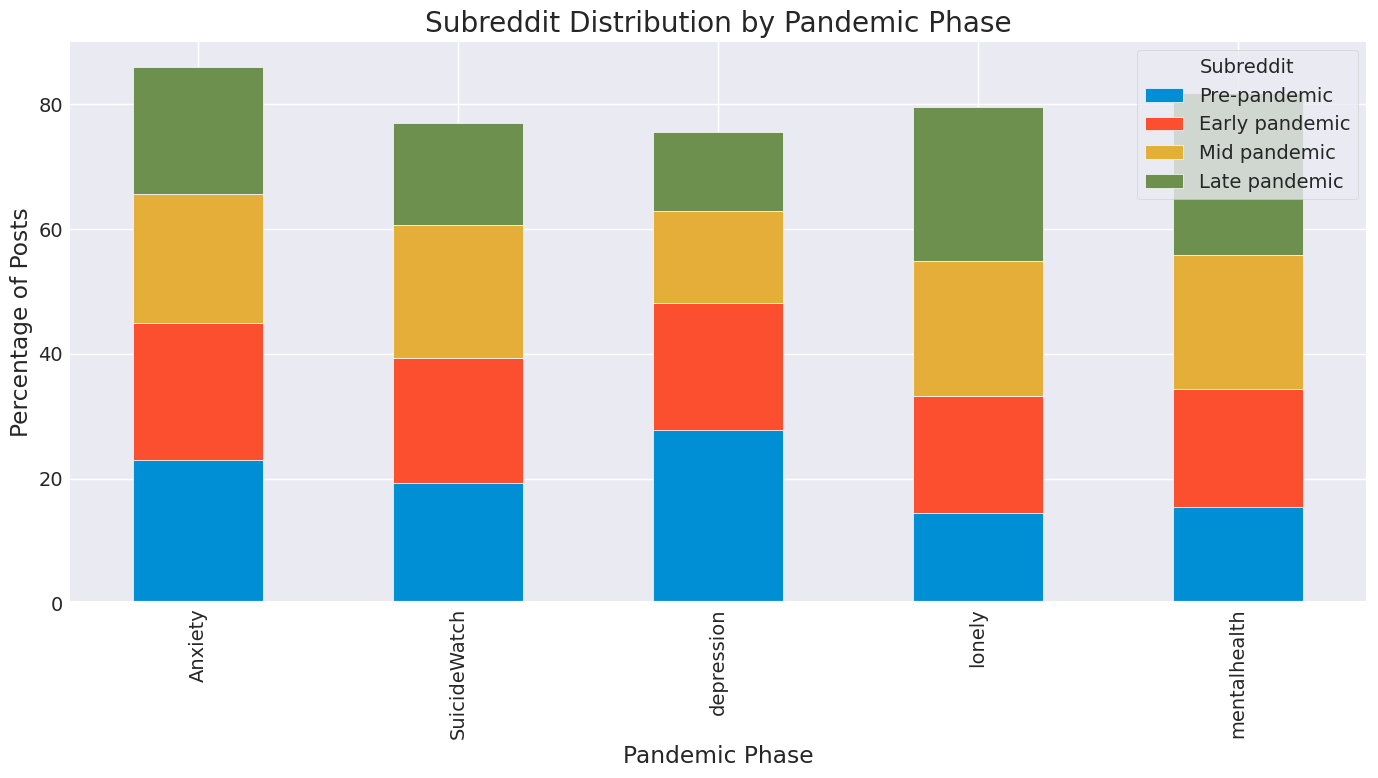

In [240]:
plt.figure(figsize=(14, 8))
pandemic_subreddit_pct.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Subreddit Distribution by Pandemic Phase')
plt.xlabel('Pandemic Phase')
plt.ylabel('Percentage of Posts')
plt.legend(title='Subreddit')
plt.tight_layout()
plt.show()

## Saving the Dataset

In [241]:
OUTPUT_PATH = os.path.join(os.getcwd(), "data", "RHMD_Engineered.csv")
df.to_csv(OUTPUT_PATH, index=False)